In [1]:
%%capture output
!pip install transformer-lens matplotlib numpy==1.25.2 seaborn scipy

# Installation and Helper Functions

In [2]:
import gc
import math
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
from transformer_lens import HookedTransformer
from transformers import AutoModel, AutoTokenizer, AutoModelForCausalLM

%matplotlib inline


# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

device = "cuda"
model = None

In [3]:
# Get sequence

def get_sequence(n: int = 10):
    # Generate 10 random digits (0-9)
    first_sequence = np.random.randint(0, 10, n)
    repeated_sequence = first_sequence.copy()
    return np.concatenate([first_sequence, repeated_sequence])

def create_masked_sequence(tokenizer, model, digit_sequence, masked_positions=None, mask_token_id=126336):
    """
    Create a tokenized sequence with specific positions masked for LLaDA.

    Args:
        tokenizer: LLaDA tokenizer
        model: LLaDA model (for device)
        digit_sequence: Array of digits (from get_sequence())
        masked_positions: List of positions to mask (0-indexed, excluding BOS)
        mask_token_id: Token ID for mask (default 126336 for LLaDA)

    Returns:
        input_ids: Tensor of shape [1, seq_len] on model device
        token_strings: List of token strings for visualization
        actual_masked_positions: Positions actually masked (accounting for BOS)
    """
    # Tokenize digits
    digit_tokens = []
    for digit in digit_sequence:
        token_ids = tokenizer(str(digit), add_special_tokens=False)['input_ids']
        digit_tokens.extend(token_ids)

    # Create input with BOS token
    input_ids = torch.tensor([[tokenizer.bos_token_id] + digit_tokens]).to(model.device)

    # Create token strings for visualization
    token_strings = ['<|BOS|>'] + [str(d) for d in digit_sequence]

    # Apply masking if specified
    actual_masked_positions = []
    if masked_positions is not None:
        for pos in masked_positions:
            if 0 <= pos < len(digit_tokens):  # Validate position
                actual_pos = pos + 1  # Account for BOS token
                input_ids[0, actual_pos] = mask_token_id
                token_strings[actual_pos] = '[MASK]'
                actual_masked_positions.append(actual_pos)

    return input_ids, token_strings, actual_masked_positions

def plot_top_induction_heads(top_heads, attention_patterns, token_strings, n_plots=12, masked_positions=None):
    """
    Plot the top N induction head candidates in a grid layout

    Args:
        top_heads: List of (layer, head, score) tuples
        attention_patterns: [n_layers, batch, n_heads, seq_len, seq_len]
        token_strings: list of token strings
        n_plots: number of heads to plot
        masked_positions: list of masked token positions to highlight
    """

    # Calculate grid dimensions (prefer more columns than rows)
    if n_plots <= 4:
        rows, cols = 1, n_plots
    elif n_plots <= 6:
        rows, cols = 2, 3
    elif n_plots <= 9:
        rows, cols = 3, 3
    elif n_plots <= 12:
        rows, cols = 3, 4
    else:
        rows, cols = 4, 4

    fig, axes = plt.subplots(rows, cols, figsize=(7 * cols, 7 * rows))
    fig.suptitle(
        f'Top Induction Head Candidates - LLaDA-8B',
        fontsize=16, fontweight='bold')

    # Handle single plot case
    if n_plots == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes.reshape(1, -1)
    elif cols == 1:
        axes = axes.reshape(-1, 1)

    seq_mid = math.ceil(len(token_strings) / 2)

    for i, (layer, head, score) in enumerate(top_heads[:n_plots]):
        row = i // cols
        col = i % cols
        ax = axes[row, col]

        # Extract attention pattern for this head
        pattern = attention_patterns[layer, 0, head, :, :].cpu().float().numpy()

        # Create heatmap
        sns.heatmap(
            pattern,
            ax=ax,
            cmap='Blues',
            cbar=False,
            # Smart axis labeling - only show on bottom row and left column
            xticklabels=token_strings,
            yticklabels=token_strings if (col == 0 and len(token_strings) <= 25) else False,
            vmin=0,
            vmax=1
        )
        # Labels
        step = max(1, len(token_strings) // 20)
        sparse_labels = [token_strings[i] if i % step == 0 else '' for i in range(len(token_strings))]
        xticklabels = sparse_labels if row == rows-1 else False
        yticklabels = sparse_labels if col == 0 else False

        # Add dividing lines to show first vs second sequence
        ax.axhline(y=seq_mid, color='red', linestyle='--', alpha=0.8,
                   linewidth=2)
        ax.axvline(x=seq_mid, color='red', linestyle='--', alpha=0.8,
                   linewidth=2)

        # Highlight masked positions if provided
        if masked_positions:
            colors = ['red', 'orange', 'green', 'purple', 'cyan']
            for i, mask_pos in enumerate(masked_positions):
                color = colors[i % len(colors)]  # Cycle through colors
                # Highlight destination (row) for masked tokens with colored rectangle
                ax.add_patch(plt.Rectangle((0, mask_pos), len(token_strings), 1,
                                         fill=False, edgecolor=color, linewidth=3))

        # Color-code the title based on score
        if score > 0.2:
            title_color = 'red'
            title_prefix = 'FIRE'
        elif score > 0.1:
            title_color = 'orange'
            title_prefix = 'STRONG'
        elif score > 0.05:
            title_color = 'blue'
            title_prefix = 'MOD'
        else:
            title_color = 'black'
            title_prefix = 'WEAK'

        ax.set_title(f'{title_prefix} L{layer}H{head}\nScore: {score:.3f}',
                     fontweight='bold', color=title_color, fontsize=12)

        ax.set_xlabel('Source Position', fontsize=10)
        ax.set_ylabel('Dest Position', fontsize=10)

    # Hide unused subplots
    for i in range(n_plots, rows * cols):
        row = i // cols
        col = i % cols
        axes[row, col].set_visible(False)

    plt.tight_layout()
    plt.show()

def detect_diffusion_model(pattern, threshold=1e-5):
    return pattern.triu(1).max() > threshold

def compute_induction_score(attention_pattern, token_sequence, mode="next", is_diffusion=None, masked_positions=None):
    if is_diffusion is None:
        is_diffusion = detect_diffusion_model(attention_pattern)

    seq_len = len(token_sequence)
    n_tokens = (seq_len - 1) // 2
    first_half_start = 1
    second_half_start = 1 + n_tokens

    def should_include_position(pos, pattern_type):
        """Check if position should be included based on masking"""
        if masked_positions is None:
            return True
        if pos in masked_positions:
            if pattern_type in ["next", "exact"] and pos < seq_len - 1 and token_sequence[pos + 1].item() != 126336:
                return True
            if pattern_type == "prev" and pos > 1 and token_sequence[pos - 1].item() != 126336:
                return True
            if pattern_type == "exact":
                return True  # For exact mode, we care about the masked position itself
        return False

    def compute_retrospective_pattern(pattern_type):
        """Second half -> First half (standard induction)"""
        total_attention = 0.0
        valid_positions = 0

        for i in range(n_tokens):
            second_pos = second_half_start + i

            # Skip if this destination position wasn't masked
            if not should_include_position(second_pos, pattern_type):
                continue

            first_pos = first_half_start + i

            if pattern_type == "next":
                target_pos = first_pos + 1
            elif pattern_type == "prev":
                target_pos = first_pos - 1
            elif pattern_type == "exact":
                target_pos = first_pos  # Attend to the exact corresponding position
            else:
                raise NotImplementedError

            if target_pos <= 0 or target_pos >= seq_len:
                continue

            attention = attention_pattern[second_pos, target_pos].item()
            total_attention += attention
            valid_positions += 1

        return total_attention, valid_positions

    def compute_anticipatory_pattern(pattern_type):
        """First half -> Second half (only for diffusion models)"""
        if not is_diffusion:
            return 0.0, 0

        total_attention = 0.0
        valid_positions = 0

        for i in range(n_tokens):
            first_pos = first_half_start + i

            # Skip if this destination position wasn't masked
            if not should_include_position(first_pos, pattern_type):
                continue

            second_pos = second_half_start + i

            if pattern_type == "next":
                target_pos = second_pos + 1
            elif pattern_type == "prev":
                target_pos = second_pos - 1
            elif pattern_type == "exact":
                target_pos = second_pos  # Attend to the exact corresponding position
            else:
                raise NotImplementedError

            if target_pos <= 0 or target_pos >= seq_len:
                continue
            
            attention = attention_pattern[first_pos, target_pos].item()
            total_attention += attention
            valid_positions += 1
        
        return total_attention, valid_positions
    
    def compute_pattern_score(pattern_type):
        retro_attention, retro_valid = compute_retrospective_pattern(pattern_type)
        antic_attention, antic_valid = compute_anticipatory_pattern(pattern_type)
        
        total_attention = retro_attention + antic_attention
        total_valid = retro_valid + antic_valid
        
        if total_valid > 0:
            return total_attention / total_valid, total_valid
        return 0.0, 0
    
    # Compute scores based on mode
    if mode == "next":
        score, _ = compute_pattern_score("next")
        return score
    elif mode == "prev":
        score, _ = compute_pattern_score("prev")
        return score
    elif mode == "exact":
        score, _ = compute_pattern_score("exact")
        return score
    elif mode == "both":
        next_score, next_valid = compute_pattern_score("next")
        prev_score, prev_valid = compute_pattern_score("prev")
        
        total_valid = next_valid + prev_valid
        if total_valid > 0:
            return (next_score * next_valid + prev_score * prev_valid) / total_valid
        return 0.0
    elif mode == "all":
        # New mode that combines next, prev, and exact
        next_score, next_valid = compute_pattern_score("next")
        prev_score, prev_valid = compute_pattern_score("prev")
        exact_score, exact_valid = compute_pattern_score("exact")
        
        total_valid = next_valid + prev_valid + exact_valid
        if total_valid > 0:
            return (next_score * next_valid + prev_score * prev_valid + exact_score * exact_valid) / total_valid
        return 0.0
    else:
        raise ValueError(f"Invalid mode: {mode}. Must be 'next', 'prev', 'exact', 'both', or 'all'")


def analyze_all_heads_induction(attention_patterns, token_sequence, token_strings, mode="next", is_diffusion=None, masked_positions=None):
    """
    Updated version that can handle the new exact mode.
    Analyze all attention heads for induction behavior and rank them.
    
    Args:
        attention_patterns: [n_layers, batch, n_heads, seq_len, seq_len] 
        token_sequence: [seq_len] token IDs
        token_strings: list of token strings
        mode: str - "next", "prev", "exact", or "both" induction pattern to analyze
        is_diffusion: bool or None - if None, auto-detect from first head
        masked_positions: list of int or None - only score these positions
    
    Returns:
        List of (layer, head, score) tuples sorted by score
    """
    
    n_layers, _, n_heads, _, _ = attention_patterns.shape
    head_scores = []
    
    if is_diffusion is None:
        is_diffusion = detect_diffusion_model(attention_patterns[0, 0, 0, :, :].cpu())
    
    model_type = "diffusion (bidirectional)" if is_diffusion else "autoregressive (causal)"
    mask_info = f" (masked positions only: {len(masked_positions)})" if masked_positions else " (all positions)"
    
    print(f"Computing induction scores for {model_type} model{mask_info}...")
    
    for layer in range(n_layers):
        for head in range(n_heads):
            pattern = attention_patterns[layer, 0, head, :, :].cpu()
            score = compute_induction_score(pattern, token_sequence, mode=mode, is_diffusion=is_diffusion, masked_positions=masked_positions)
            head_scores.append((layer, head, score))
    
    head_scores.sort(key=lambda x: x[2], reverse=True)
    return head_scores


def extract_llada_attention_patterns(model, input_ids, validation_mode=False):
    """
    Extract attention patterns from LLaDA model using hooks.
    This function can be used both for validation and analysis.

    Args:
        model: LLaDA model
        input_ids: input token IDs [batch, seq_len]
        validation_mode: if True, also return validation data

    Returns:
        attention_patterns: [n_layers, batch, n_heads, seq_len, seq_len]
        validation_data: dict with validation info (if validation_mode=True)
    """

    n_layers = len(model.model.transformer.blocks)
    batch_size, seq_len = input_ids.shape

    # Storage for captured data
    captured_qkv = {}
    captured_attention_outputs = {}
    hooks = []

    # Hook functions
    def capture_qkv_hook(name):
        def hook(module, input, output):
            captured_qkv[name] = output.detach()
        return hook

    def capture_attention_output_hook(layer_idx):
        def hook(module, input, output):
            captured_attention_outputs[layer_idx] = output.detach()
        return hook

    # Register hooks for all layers
    for layer_idx in range(n_layers):
        block = model.model.transformer.blocks[layer_idx]

        # Capture Q, K, V projections
        hooks.append(block.q_proj.register_forward_hook(capture_qkv_hook(f'q_{layer_idx}')))
        hooks.append(block.k_proj.register_forward_hook(capture_qkv_hook(f'k_{layer_idx}')))
        hooks.append(block.v_proj.register_forward_hook(capture_qkv_hook(f'v_{layer_idx}')))

        # Capture attention output for validation if needed
        if validation_mode:
            hooks.append(block.attn_out.register_forward_hook(capture_attention_output_hook(layer_idx)))

    try:
        # Run forward pass to capture data
        with torch.inference_mode():
            _ = model(input_ids)

        # Extract attention patterns for all layers
        all_attention_weights = []
        validation_results = {}

        for layer_idx in range(n_layers):
            block = model.model.transformer.blocks[layer_idx]
            config = block.config

            # Get captured Q, K, V for this layer
            q = captured_qkv[f'q_{layer_idx}']
            k = captured_qkv[f'k_{layer_idx}']
            v = captured_qkv[f'v_{layer_idx}']

            B, T, C = q.shape
            dtype = q.dtype

            # Apply q/k norm if present
            if hasattr(block, 'q_norm') and block.q_norm is not None:
                q = block.q_norm(q).to(dtype=dtype)
            if hasattr(block, 'k_norm') and block.k_norm is not None:
                k = block.k_norm(k).to(dtype=dtype)

            # Reshape to heads
            q_heads = q.view(B, T, config.n_heads, C // config.n_heads).transpose(1, 2)
            k_heads = k.view(B, T, config.effective_n_kv_heads, C // config.n_heads).transpose(1, 2)
            v_heads = v.view(B, T, config.effective_n_kv_heads, C // config.n_heads).transpose(1, 2)

            # Apply rotary embeddings (CRITICAL)
            if config.rope:
                q_heads, k_heads = block.rotary_emb(q_heads, k_heads)

            # Handle GQA (repeat K/V heads if needed)
            if config.n_heads != config.effective_n_kv_heads:
                n_rep = config.n_heads // config.effective_n_kv_heads
                k_heads = torch.repeat_interleave(k_heads, n_rep, dim=1)
                v_heads = torch.repeat_interleave(v_heads, n_rep, dim=1)

            # Compute attention scores and weights
            scale = 1.0 / (q_heads.shape[-1] ** 0.5)
            attention_scores = torch.matmul(q_heads, k_heads.transpose(-2, -1)) * scale
            attention_weights = F.softmax(attention_scores, dim=-1)

            # Store attention weights for this layer
            all_attention_weights.append(attention_weights)

            # Validation: compare with actual attention output if requested
            if validation_mode and layer_idx in captured_attention_outputs:
                # Compute manual attention output
                ctx_manual = torch.matmul(attention_weights, v_heads)
                att_reassembled = ctx_manual.transpose(1, 2).contiguous().view(B, T, C)
                manual_attention_output = block.attn_out(att_reassembled)

                # Compare with captured output
                actual_output = captured_attention_outputs[layer_idx]
                mae = (actual_output - manual_attention_output).abs().mean().item()
                max_diff = (actual_output - manual_attention_output).abs().max().item()

                validation_results[layer_idx] = {
                    'mae': mae,
                    'max_diff': max_diff,
                    'passed': mae < 1e-3 and max_diff < 1e-2  # Reasonable thresholds for bfloat16
                }

        # Stack all attention weights into the expected format
        attention_patterns = torch.stack(all_attention_weights)  # [n_layers, batch, n_heads, seq_len, seq_len]

        if validation_mode:
            return attention_patterns, validation_results
        else:
            return attention_patterns

    finally:
        # Clean up hooks
        for hook in hooks:
            hook.remove()
        gc.collect()
        torch.cuda.empty_cache()
        print("🧹 Memory cleaned up")

# GPT-2 Experiment

In [ ]:
print("Loading GPT-2 Small...")
model = HookedTransformer.from_pretrained("gpt2-small")
print(f"✓ Model loaded: {model.cfg.n_layers} layers, {model.cfg.n_heads} heads per layer")

In [ ]:
# Generate 10 random digits, then repeat them exactly
print("Creating test sequence...")

# Generate 10 random digits (0-9)
first_sequence = np.random.randint(0, 10, 10)
repeated_sequence = first_sequence.copy()

# Combine them
full_sequence = np.concatenate([first_sequence, repeated_sequence])

# Convert to text (so tokenizer can handle it)
text_sequence = ' '.join(map(str, full_sequence))
print(f"Test sequence: {text_sequence}")
print(f"First part:    {text_sequence[:19]}")  
print(f"Second part:   {text_sequence[19:]}")
print(f"Are they same? {text_sequence[:19] == text_sequence[20:]}")

In [15]:
# ==============================================================================
# TOKENIZE AND RUN MODEL
# ==============================================================================

print("\nTokenizing and running model...")

# Tokenize the sequence
tokens = model.to_tokens(text_sequence)
print(f"Tokens shape: {tokens.shape}")
print(f"Token IDs: {tokens[0].tolist()}")

# Get the actual token strings
token_strings = model.to_str_tokens(text_sequence)
print(f"Token strings: {token_strings}")

# Run model with attention caching
logits, cache = model.run_with_cache(tokens)

# Extract attention patterns
attention_patterns = cache.stack_activation("pattern")  # Shape: [layers, heads, seq_len, seq_len]
print(f"Attention patterns shape: {attention_patterns.shape}")

n_layers, _, n_heads, seq_len, _ = attention_patterns.shape


Tokenizing and running model...
Tokens shape: torch.Size([1, 21])
Token IDs: [50256, 18, 767, 767, 362, 642, 604, 352, 767, 642, 352, 513, 767, 767, 362, 642, 604, 352, 767, 642, 352]
Token strings: ['<|endoftext|>', '3', ' 7', ' 7', ' 2', ' 5', ' 4', ' 1', ' 7', ' 5', ' 1', ' 3', ' 7', ' 7', ' 2', ' 5', ' 4', ' 1', ' 7', ' 5', ' 1']
Attention patterns shape: torch.Size([12, 1, 12, 21, 21])


In [45]:
# ==============================================================================
# VISUALIZATION FUNCTIONS
# ==============================================================================

def plot_attention_layer_grid(layer, attention_patterns, token_strings):
    """Plot all 12 heads for a single layer in a 3x4 grid"""
    
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    fig.suptitle(f'🔍 Layer {layer} - All Attention Heads\n(Look for cross-sequence diagonal patterns!)', 
                 fontsize=16, fontweight='bold')
    
    seq_mid = len(token_strings) // 2
    
    # Keep track of potential induction heads for this layer
    potential_induction_heads = []
    
    for head in range(12):  # GPT-2 small has 12 heads per layer
        row, col = head // 4, head % 4
        ax = axes[row, col]
        
        # Extract attention pattern for this head (fix the indexing bug)
        pattern = attention_patterns[layer, :, head, :, :].squeeze(0).cpu()
        
        # Create heatmap
        sns.heatmap(
            pattern.numpy(), 
            ax=ax,
            cmap='Blues',
            square=True,
            cbar=False,  # No individual colorbars to save space
            xticklabels=token_strings if head >= 8 else False,  # Only show x-labels on bottom row
            yticklabels=token_strings if head % 4 == 0 else False,  # Only show y-labels on leftmost column
            vmin=0,
            vmax=1
        )
        
        # Add dividing lines to show first vs second sequence
        ax.axhline(y=seq_mid, color='red', linestyle='--', alpha=0.8, linewidth=1.5)
        ax.axvline(x=seq_mid, color='red', linestyle='--', alpha=0.8, linewidth=1.5)
        
        # Quick analysis for induction head detection
        first_half = seq_len // 2
        cross_attention = pattern[first_half:, :first_half].mean().item()
        
        # Color-code the title based on cross-attention strength
        if cross_attention > 0.15:
            title_color = 'red'
            title = f'Head {head} 🚨\n({cross_attention:.3f})'
            potential_induction_heads.append((head, cross_attention))
        elif cross_attention > 0.08:
            title_color = 'orange' 
            title = f'Head {head} ⚠️\n({cross_attention:.3f})'
        else:
            title_color = 'black'
            title = f'Head {head}\n({cross_attention:.3f})'
        
        ax.set_title(title, fontweight='bold', color=title_color, fontsize=10)
        
        # Clean up axes
        if head < 8:  # Not bottom row
            ax.set_xlabel('')
        else:
            ax.set_xlabel('Source Position', fontsize=8)
            
        if head % 4 != 0:  # Not leftmost column
            ax.set_ylabel('')
        else:
            ax.set_ylabel('Dest Position', fontsize=8)
    
    # Add a colorbar for the entire figure
    fig.subplots_adjust(right=0.92)
    cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])
    sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label('Attention Weight', rotation=270, labelpad=15)
    
    plt.tight_layout()
    plt.show()
    
    # Print analysis for this layer
    print(f"\n📊 Layer {layer} Analysis:")
    if potential_induction_heads:
        print("🚨 POTENTIAL INDUCTION HEADS found:")
        for head, score in sorted(potential_induction_heads, key=lambda x: x[1], reverse=True):
            print(f"   • Head {head}: Cross-attention = {score:.3f}")
    else:
        print("   No strong induction head candidates in this layer")
    
    return potential_induction_heads

# ==============================================================================
# PLOT ALL LAYERS IN GRIDS
# ==============================================================================

print(f"\n🎯 Visualizing all {n_layers} layers with {n_heads} heads each...")
print("🔍 LEGEND:")
print("   🚨 Red titles = Strong induction candidates (>0.15)")
print("   ⚠️ Orange titles = Moderate candidates (>0.08)")
print("   Black titles = Weak/no induction pattern")
print("\n👀 WHAT TO LOOK FOR:")
print("   • Bright blue squares in bottom-left quadrant")
print("   • Diagonal patterns shifted by +1 position")
print("   • Strong cross-sequence attention scores")

all_induction_candidates = []

for layer in range(n_layers):
    print(f"\n{'='*60}")
    print(f"🔍 ANALYZING LAYER {layer}")
    print(f"{'='*60}")
    
    # Plot the entire layer as a grid
    candidates = plot_attention_layer_grid(layer, attention_patterns, token_strings)
    
    # Store results
    for head, score in candidates:
        all_induction_candidates.append((layer, head, score))


🎯 Visualizing all 32 layers with 32 heads each...
🔍 LEGEND:
   🚨 Red titles = Strong induction candidates (>0.15)
   ⚠️ Orange titles = Moderate candidates (>0.08)
   Black titles = Weak/no induction pattern

👀 WHAT TO LOOK FOR:
   • Bright blue squares in bottom-left quadrant
   • Diagonal patterns shifted by +1 position
   • Strong cross-sequence attention scores

🔍 ANALYZING LAYER 0


NameError: name 'attention_patterns' is not defined

# CHECK QWEN3

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "Qwen/Qwen3-0.6B"

# load the tokenizer and the model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto",
    attn_implementation="eager",
)

# prepare the model input
prompt = "Give me a short introduction to large language model."
messages = [
    {"role": "user", "content": prompt}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize=False,
    add_generation_prompt=True,
    enable_thinking=False # Switches between thinking and non-thinking modes. Default is True.
)
model_inputs = tokenizer([text], return_tensors="pt").to(model.device)

# conduct text completion
generated_ids = model.generate(
    **model_inputs,
    max_new_tokens=32768
)
output_ids = generated_ids[0][len(model_inputs.input_ids[0]):].tolist() 

# parsing thinking content
try:
    # rindex finding 151668 (</think>)
    index = len(output_ids) - output_ids[::-1].index(151668)
except ValueError:
    index = 0

thinking_content = tokenizer.decode(output_ids[:index], skip_special_tokens=True).strip("\n")
content = tokenizer.decode(output_ids[index:], skip_special_tokens=True).strip("\n")

print("thinking content:\n", thinking_content)
print("="*50)
print("content:\n", content)

In [111]:
# Run the model
with torch.no_grad():
    outputs = model(model_inputs["input_ids"], output_attentions=True)


In [ ]:
len(outputs.attentions)

# LLAMA-8B Induction heads

In [4]:
# LOAD LLAMA model

print("Loading LLaMA-8B-Base...")
model_name = "meta-llama/Llama-3.1-8B"

# cleanup
del model
gc.collect()
torch.cuda.empty_cache()

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    attn_implementation="eager",  # Required for output_attentions
)

print(
    f"✓ Model loaded: {model.config.num_hidden_layers} layers, {model.config.num_attention_heads} heads per layer")
print(
    f"✓ Model parameters: ~{sum(p.numel() for p in model.parameters()) / 1e9:.1f}B")

Loading LLaMA-8B-Base...


tokenizer_config.json:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/73.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/826 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/185 [00:00<?, ?B/s]

✓ Model loaded: 32 layers, 32 heads per layer
✓ Model parameters: ~8.0B


In [5]:
# GENERATE AND TOKENIZE
print("Creating test sequence for LLAMA-8B...")

np.random.seed(42)
digit_sequence = get_sequence()
digit_tokens = []

for digit in digit_sequence:
    token_ids = tokenizer(str(digit), add_special_tokens=False)['input_ids']
    digit_tokens.extend(token_ids)

# Add BOS token
input_ids = torch.tensor([[tokenizer.bos_token_id] + digit_tokens]).to(model.device)
token_strings = ['<BOS>'] + [str(d) for d in digit_sequence]

print(f"Input IDs shape: {input_ids.shape}")
print(f"Token IDs: {input_ids[0].tolist()}")

# Get the actual token strings
tokens = input_ids[0].tolist()
token_strings = [tokenizer.decode([token]) for token in tokens]
print(f"Token strings: {token_strings}")

Creating test sequence for LLAMA-8B...
Input IDs shape: torch.Size([1, 21])
Token IDs: [128000, 21, 18, 22, 19, 21, 24, 17, 21, 22, 19, 21, 18, 22, 19, 21, 24, 17, 21, 22, 19]
Token strings: ['<|begin_of_text|>', '6', '3', '7', '4', '6', '9', '2', '6', '7', '4', '6', '3', '7', '4', '6', '9', '2', '6', '7', '4']


Running forward pass with attention capture...
Number of attention layers: 32
Attention tensor shape per layer: torch.Size([1, 32, 21, 21])
Stacked attention patterns shape: torch.Size([32, 1, 32, 21, 21])

🎯 PRECISION INDUCTION HEAD ANALYSIS - LLaMA-8B
🎯 Computing precise induction scores for all heads...
   (Measuring: 'attend to token after previous repetition')

🏆 TOP 20 INDUCTION HEADS (by precision score):
   Rank | Layer | Head | Score | Interpretation
   -----|-------|------|-------|---------------
    1.   |   5  |  11  | 0.295 | 🔥 EXCELLENT
    2.   |  15  |  30  | 0.293 | 🔥 EXCELLENT
    3.   |   2  |  22  | 0.219 | 🔥 EXCELLENT
    4.   |  16  |  20  | 0.219 | 🔥 EXCELLENT
    5.   |   8  |   1  | 0.181 | 💪 STRONG  
    6.   |  16  |  23  | 0.169 | 💪 STRONG  
    7.   |  20  |   1  | 0.122 | 💪 STRONG  
    8.   |  23  |  14  | 0.103 | 💪 STRONG  
    9.   |  19  |   3  | 0.093 | ⚡ MODERATE
   10.   |  16  |   1  | 0.090 | ⚡ MODERATE
   11.   |   2  |  26  | 0.086 | ⚡ MODERATE


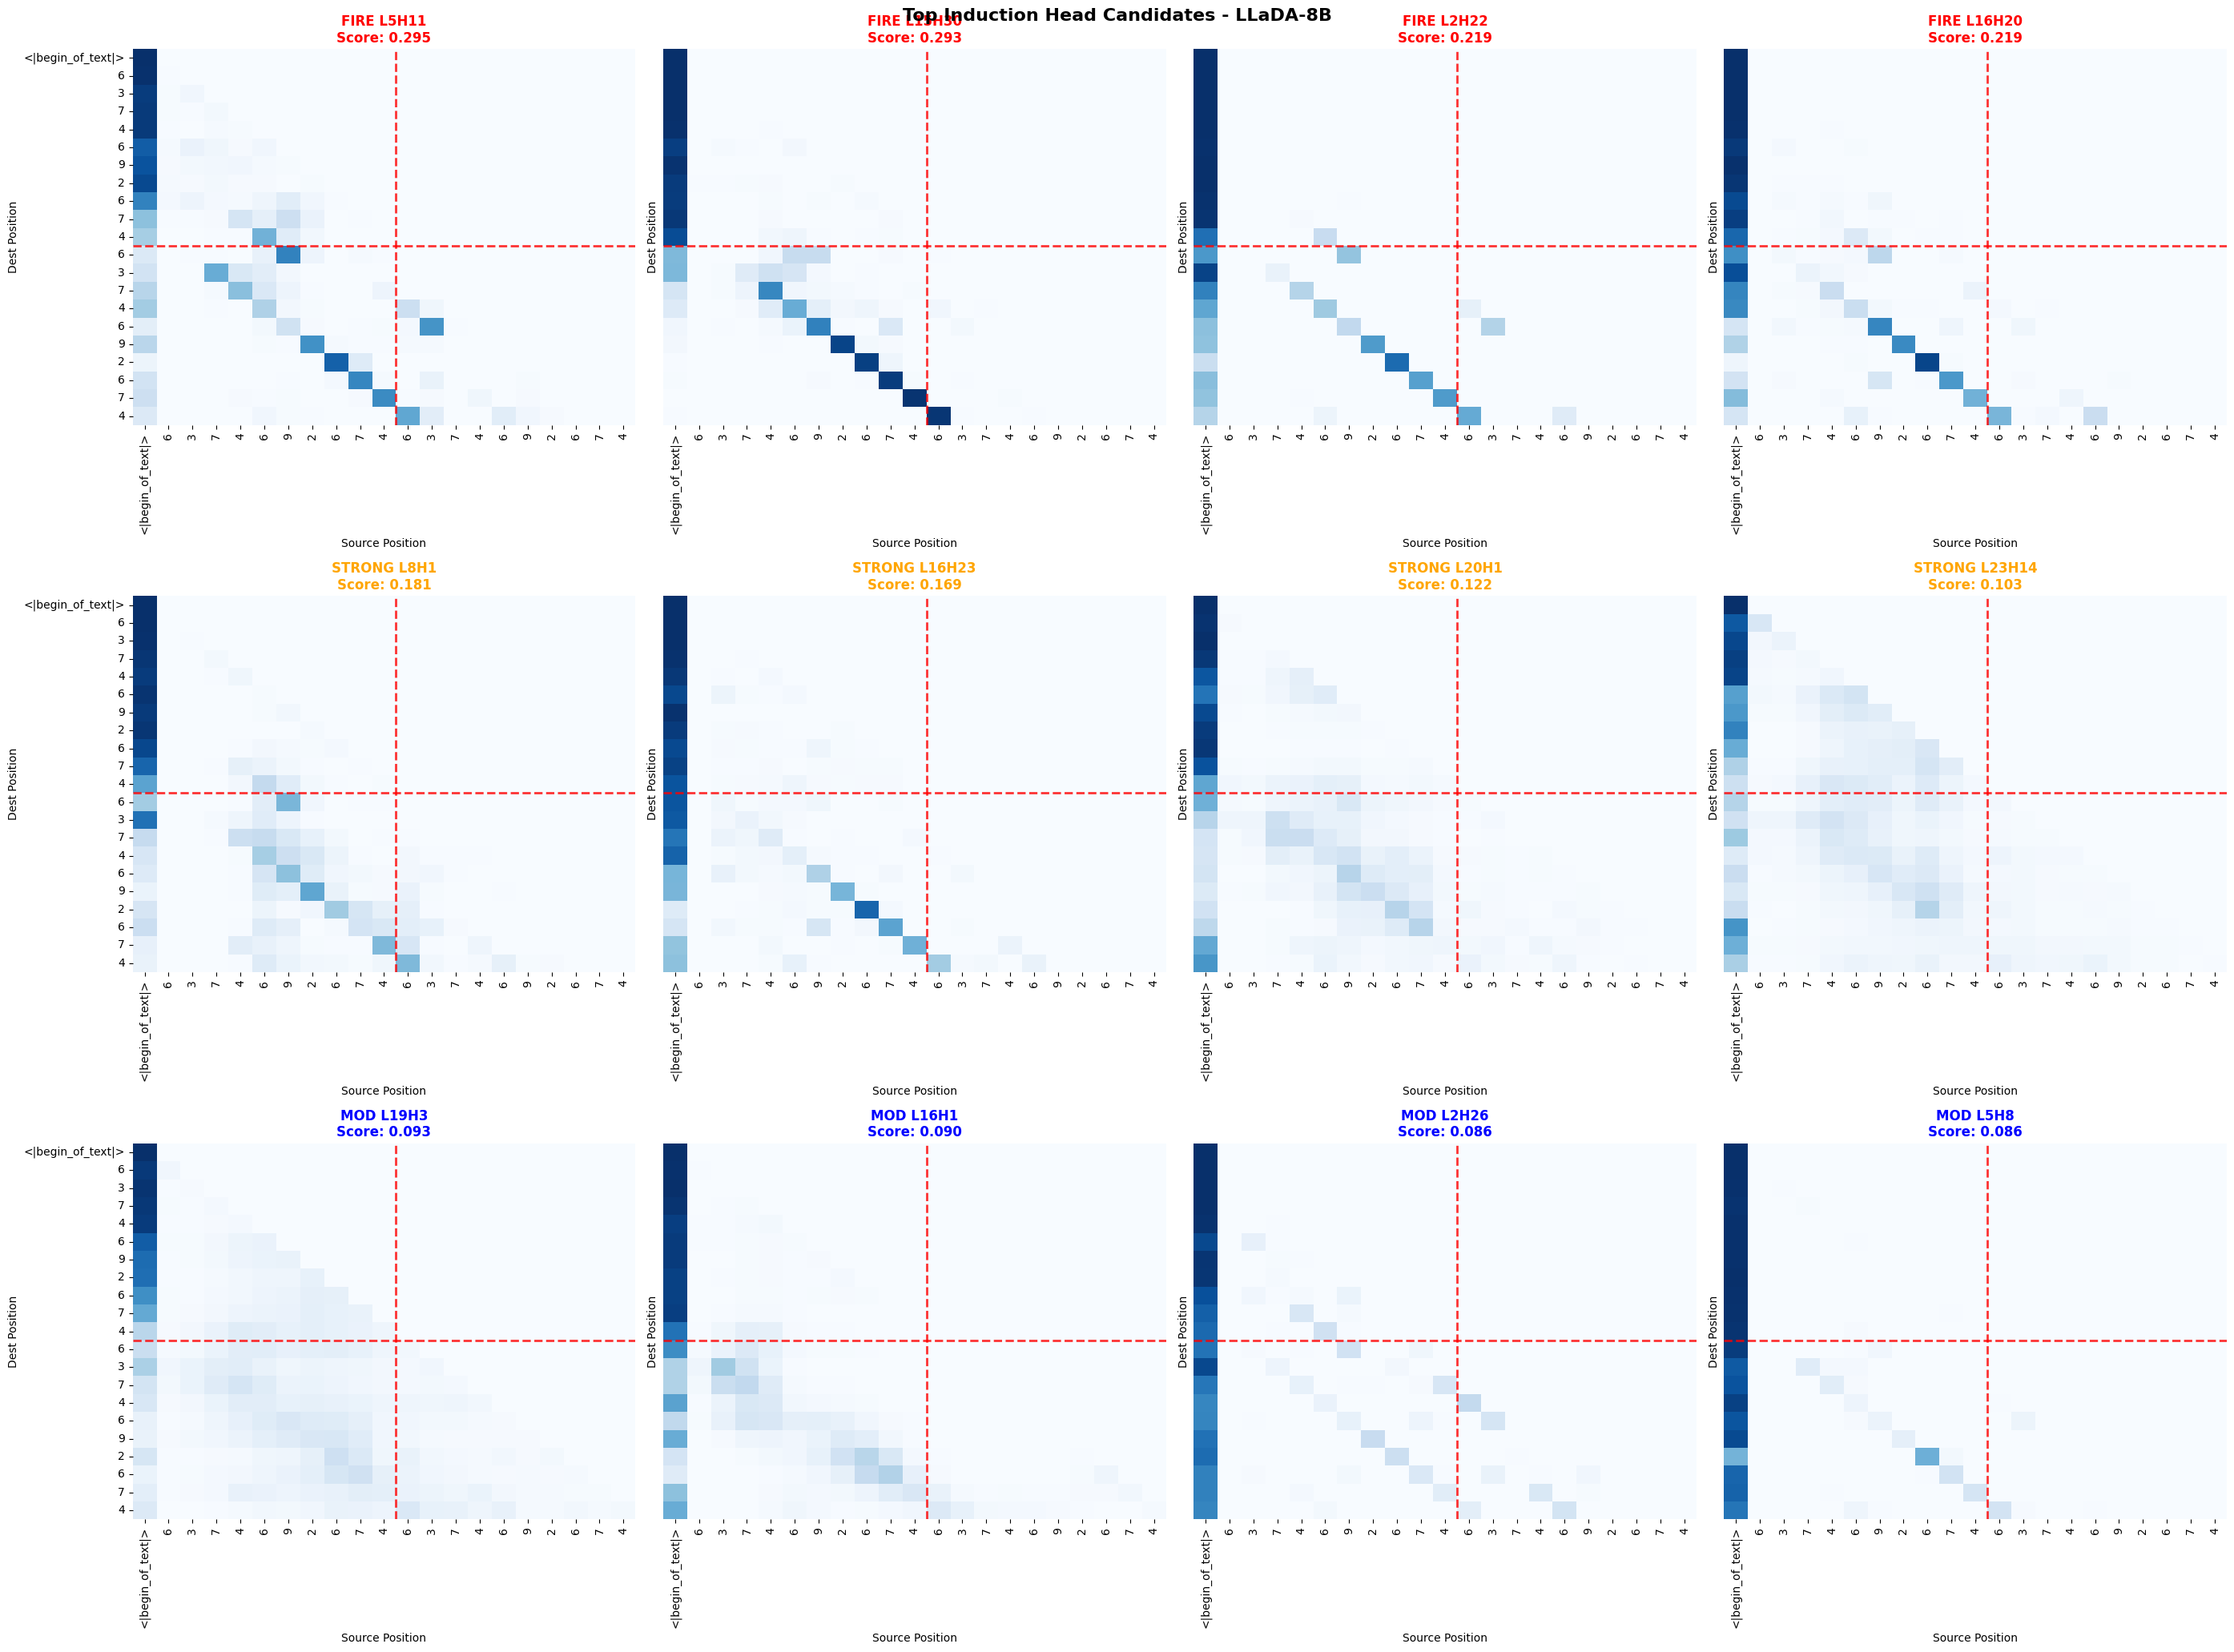


📈 SUMMARY STATISTICS - LLaMA-8B INDUCTION HEADS
📊 SCORE DISTRIBUTION:
   🔥 Strong heads (>0.1):       8 (0.8%)
   ⚡ Moderate heads (0.05-0.1):  47 (4.6%)
   ❌ Weak heads (≤0.05):       969 (94.6%)

📈 STATISTICAL SUMMARY:
   Mean score:    0.0143
   Median score:  0.0075
   Std dev:       0.0234
   Max score:     0.2945
   Min score:     0.0000

🏗️ TOP HEADS BY LAYER (Top 20):
   Layer  2:  3 heads (15.0%) ███
   Layer  5:  2 heads (10.0%) ██
   Layer  8:  2 heads (10.0%) ██
   Layer 15:  2 heads (10.0%) ██
   Layer 16:  3 heads (15.0%) ███
   Layer 19:  1 heads ( 5.0%) █
   Layer 20:  1 heads ( 5.0%) █
   Layer 22:  1 heads ( 5.0%) █
   Layer 23:  1 heads ( 5.0%) █
   Layer 27:  1 heads ( 5.0%) █
   Layer 28:  1 heads ( 5.0%) █
   Layer 30:  2 heads (10.0%) ██

🎉 ANALYSIS COMPLETE!
   ✓ Analyzed 1024 attention heads across 32 layers
   ✓ Found 8 strong induction head candidates
   ✓ Ready for comparison with LLaDA-8B results!


In [7]:
# ==============================================================================
# PRECISION INDUCTION SCORING FUNCTION
# ==============================================================================

def compute_induction_score(attention_pattern, token_sequence, verbose=False):
    """
    Compute precise induction score based on the specific pattern:
    "In the second half, attend to the position right after the previous repetition"
    
    Args:
        attention_pattern: [seq_len, seq_len] attention weights
        token_sequence: [seq_len] token IDs  
        verbose: Print detailed analysis
    
    Returns:
        float: Induction score (higher = more induction-like)
    """
    
    seq_len = len(token_sequence)
    first_half_len = seq_len // 2
    
    total_induction_attention = 0.0
    valid_positions = 0
    
    if verbose:
        print("   🔍 Detailed induction analysis:")
    
    # Analyze each position in the second half
    for second_pos in range(first_half_len, seq_len):
        current_token = token_sequence[second_pos].item()
        
        # Find where this token FIRST appeared in the first half
        first_occurrence_pos = None
        for first_pos in range(first_half_len):
            if token_sequence[first_pos].item() == current_token:
                first_occurrence_pos = first_pos
                break
        
        # If token exists in first half and there's a "next" position
        if first_occurrence_pos is not None and first_occurrence_pos + 1 < seq_len:
            induction_target_pos = first_occurrence_pos + 1
            
            # How much attention does this position pay to the "induction target"?
            induction_attention = attention_pattern[second_pos, induction_target_pos].item()
            
            total_induction_attention += induction_attention
            valid_positions += 1
            
            if verbose:
                token_str = str(current_token)
                target_token = token_sequence[induction_target_pos].item()
                print(f"      Pos {second_pos} ('{token_str}') -> Pos {induction_target_pos} ('{target_token}'): {induction_attention:.3f}")
    
    # Return average induction attention
    if valid_positions > 0:
        score = total_induction_attention / valid_positions
        if verbose:
            print(f"   📊 Average induction attention: {score:.3f} ({valid_positions} valid positions)")
        return score
    else:
        return 0.0

def analyze_all_heads_induction(attention_patterns, token_sequence, token_strings):
    """
    Analyze all attention heads for induction behavior and rank them.
    
    Args:
        attention_patterns: [n_layers, batch, n_heads, seq_len, seq_len] 
        token_sequence: [seq_len] token IDs
        token_strings: list of token strings
    
    Returns:
        List of (layer, head, score) tuples sorted by score
    """
    
    n_layers, _, n_heads, _, _ = attention_patterns.shape
    head_scores = []
    
    print("🎯 Computing precise induction scores for all heads...")
    print("   (Measuring: 'attend to token after previous repetition')")
    
    for layer in range(n_layers):
        for head in range(n_heads):
            # Extract attention pattern for this head 
            pattern = attention_patterns[layer, :, head, :, :].squeeze(0).cpu()
            
            # Compute induction score
            score = compute_induction_score(pattern, token_sequence)
            
            head_scores.append((layer, head, score))
    
    # Sort by score (highest first)
    head_scores.sort(key=lambda x: x[2], reverse=True)
    
    return head_scores

# Run model with attention capture

print("Running forward pass with attention capture...")

with torch.inference_mode():
    outputs = model(input_ids, output_attentions=True)

# Extract attention patterns
attention_tuples = outputs.attentions  # List of attention tensors, one per layer
print(f"Number of attention layers: {len(attention_tuples)}")
print(
    f"Attention tensor shape per layer: {attention_tuples[0].shape}")  # [batch, heads, seq_len, seq_len]

# Stack into single tensor for easier processing
attention_patterns = torch.stack(
    attention_tuples)  # [layers, batch, heads, seq_len, seq_len]
print(f"Stacked attention patterns shape: {attention_patterns.shape}")

n_layers, batch_size, n_heads, seq_len, _ = attention_patterns.shape

# Clean up GPU memory
del outputs
gc.collect()
torch.cuda.empty_cache()

# Run precision induction analysis
print("\n" + "=" * 80)
print("🎯 PRECISION INDUCTION HEAD ANALYSIS - LLaMA-8B")
print("=" * 80)

# Convert token_strings to token IDs for analysis
token_ids = input_ids[0].cpu()  # Remove batch dimension

# Analyze all heads with the precision scoring
ranked_heads = analyze_all_heads_induction(attention_patterns, token_ids, token_strings)

print(f"\n🏆 TOP 20 INDUCTION HEADS (by precision score):")
print("   Rank | Layer | Head | Score | Interpretation")
print("   -----|-------|------|-------|---------------")

for i, (layer, head, score) in enumerate(ranked_heads[:20]):
    if score > 0.2:
        strength = "🔥 EXCELLENT"
    elif score > 0.1:
        strength = "💪 STRONG  "
    elif score > 0.05:
        strength = "⚡ MODERATE"
    else:
        strength = "❌ WEAK    "

    print(
        f"   {i + 1:2d}.   |  {layer:2d}  |  {head:2d}  | {score:.3f} | {strength}")

# Detailed analysis of top 3 heads
print(f"\n🔍 DETAILED ANALYSIS OF TOP 3 HEADS:")
print("=" * 60)

for i, (layer, head, score) in enumerate(ranked_heads[:3]):
    print(f"\n🎯 RANK {i + 1}: Layer {layer}, Head {head} (Score: {score:.3f})")
    print("-" * 50)

    # Get attention pattern
    pattern = attention_patterns[layer, 0, head, :, :].cpu()

    # Detailed analysis
    compute_induction_score(pattern, token_ids)

    # Additional insights
    seq_mid = len(token_strings) // 2
    cross_attention = pattern[seq_mid:, :seq_mid].mean().item()
    max_attention = pattern.max().item()

    print(f"   📈 Cross-sequence attention: {cross_attention:.3f}")
    print(f"   📈 Maximum attention weight: {max_attention:.3f}")

# Plot top 12 induction head candidates
print("\n📊 PLOTTING TOP 12 INDUCTION HEAD CANDIDATES")
print("=" * 60)

plot_top_induction_heads(ranked_heads, attention_patterns, token_strings, n_plots=12)

# Summary statistics
print("\n" + "=" * 80)
print("📈 SUMMARY STATISTICS - LLaMA-8B INDUCTION HEADS")
print("=" * 80)

# Score distribution analysis
all_scores = [score for _, _, score in ranked_heads]
strong_heads = [score for score in all_scores if score > 0.1]
moderate_heads = [score for score in all_scores if 0.05 < score <= 0.1]
weak_heads = [score for score in all_scores if score <= 0.05]

print(f"📊 SCORE DISTRIBUTION:")
print(
    f"   🔥 Strong heads (>0.1):     {len(strong_heads):3d} ({len(strong_heads) / len(all_scores) * 100:.1f}%)")
print(
    f"   ⚡ Moderate heads (0.05-0.1): {len(moderate_heads):3d} ({len(moderate_heads) / len(all_scores) * 100:.1f}%)")
print(
    f"   ❌ Weak heads (≤0.05):       {len(weak_heads):3d} ({len(weak_heads) / len(all_scores) * 100:.1f}%)")

print(f"\n📈 STATISTICAL SUMMARY:")
print(f"   Mean score:    {np.mean(all_scores):.4f}")
print(f"   Median score:  {np.median(all_scores):.4f}")
print(f"   Std dev:       {np.std(all_scores):.4f}")
print(f"   Max score:     {np.max(all_scores):.4f}")
print(f"   Min score:     {np.min(all_scores):.4f}")

# Layer distribution of top heads
print(f"\n🏗️ TOP HEADS BY LAYER (Top 20):")
layer_counts = {}
for layer, head, score in ranked_heads[:20]:
    layer_counts[layer] = layer_counts.get(layer, 0) + 1

for layer in sorted(layer_counts.keys()):
    count = layer_counts[layer]
    percentage = count / 20 * 100
    bar = "█" * max(1, count)
    print(f"   Layer {layer:2d}: {count:2d} heads ({percentage:4.1f}%) {bar}")

print(f"\n🎉 ANALYSIS COMPLETE!")
print(
    f"   ✓ Analyzed {len(all_scores)} attention heads across {n_layers} layers")
print(f"   ✓ Found {len(strong_heads)} strong induction head candidates")
print(f"   ✓ Ready for comparison with LLaDA-8B results!")

# LLADA Attention Exploration

In [4]:
# cleanup
del model
gc.collect()
torch.cuda.empty_cache()

tokenizer = AutoTokenizer.from_pretrained('GSAI-ML/LLaDA-8B-Instruct', trust_remote_code=True)
model = AutoModel.from_pretrained('GSAI-ML/LLaDA-8B-Instruct', trust_remote_code=True).cuda().eval()

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

configuration_llada.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/GSAI-ML/LLaDA-8B-Instruct:
- configuration_llada.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_llada.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/GSAI-ML/LLaDA-8B-Instruct:
- modeling_llada.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

model-00002-of-00006.safetensors:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

model-00004-of-00006.safetensors:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

model-00006-of-00006.safetensors:   0%|          | 0.00/2.11G [00:00<?, ?B/s]

model-00005-of-00006.safetensors:   0%|          | 0.00/2.92G [00:00<?, ?B/s]

model-00003-of-00006.safetensors:   0%|          | 0.00/2.99G [00:00<?, ?B/s]

model-00001-of-00006.safetensors:   0%|          | 0.00/2.11G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/128 [00:00<?, ?B/s]

## LLaDA Source Code for generation

In [ ]:
def add_gumbel_noise(logits, temperature):
    '''
    The Gumbel max is a method for sampling categorical distributions.
    According to arXiv:2409.02908, for MDM, low-precision Gumbel Max improves perplexity score but reduces generation quality.
    Thus, we use float64.
    '''
    if temperature == 0:
        return logits
    logits = logits.to(torch.float64)
    noise = torch.rand_like(logits, dtype=torch.float64)
    gumbel_noise = (- torch.log(noise)) ** temperature
    return logits.exp() / gumbel_noise


def get_num_transfer_tokens(mask_index, steps):
    '''
    In the reverse process, the interval [0, 1] is uniformly discretized into steps intervals.
    Furthermore, because LLaDA employs a linear noise schedule (as defined in Eq. (8)),
    the expected number of tokens transitioned at each step should be consistent.

    This function is designed to precompute the number of tokens that need to be transitioned at each step.
    '''
    mask_num = mask_index.sum(dim=1, keepdim=True)

    base = mask_num // steps
    remainder = mask_num % steps

    num_transfer_tokens = torch.zeros(mask_num.size(0), steps, device=mask_index.device, dtype=torch.int64) + base

    for i in range(mask_num.size(0)):
        num_transfer_tokens[i, :remainder[i]] += 1

    return num_transfer_tokens


@torch.inference_mode()
def generate(model, prompt, steps=128, gen_length=128, block_length=128, temperature=0.,
             cfg_scale=0., remasking='low_confidence', mask_id=126336):
    '''
    Args:
        model: Mask predictor.
        prompt: A tensor of shape (1, L).
        steps: Sampling steps, less than or equal to gen_length.
        gen_length: Generated answer length.
        block_length: Block length, less than or equal to gen_length. If less than gen_length, it means using semi_autoregressive remasking.
        temperature: Categorical distribution sampling temperature.
        cfg_scale: Unsupervised classifier-free guidance scale.
        remasking: Remasking strategy. 'low_confidence' or 'random'.
        mask_id: The toke id of [MASK] is 126336.
    '''
    x = torch.full((1, prompt.shape[1] + gen_length), mask_id, dtype=torch.long).to(model.device)
    x[:, :prompt.shape[1]] = prompt.clone()

    prompt_index = (x != mask_id)

    assert gen_length % block_length == 0
    num_blocks = gen_length // block_length

    assert steps % num_blocks == 0
    steps = steps // num_blocks

    for num_block in range(num_blocks):
        block_mask_index = (x[:, prompt.shape[1] + num_block * block_length: prompt.shape[1] + (num_block + 1) * block_length:] == mask_id)
        num_transfer_tokens = get_num_transfer_tokens(block_mask_index, steps)
        for i in range(steps):
            mask_index = (x == mask_id)
            if cfg_scale > 0.:
                un_x = x.clone()
                un_x[prompt_index] = mask_id
                x_ = torch.cat([x, un_x], dim=0)
                logits = model(x_).logits
                logits, un_logits = torch.chunk(logits, 2, dim=0)
                logits = un_logits + (cfg_scale + 1) * (logits - un_logits)
            else:
                logits = model(x).logits

            logits_with_noise = add_gumbel_noise(logits, temperature=temperature)
            x0 = torch.argmax(logits_with_noise, dim=-1) # b, l

            if remasking == 'low_confidence':
                p = F.softmax(logits, dim=-1)
                x0_p = torch.squeeze(
                    torch.gather(p, dim=-1, index=torch.unsqueeze(x0, -1)), -1) # b, l
            elif remasking == 'random':
                x0_p = torch.rand((x0.shape[0], x0.shape[1]), device=x0.device)
            else:
                raise NotImplementedError(remasking)

            x0_p[:, prompt.shape[1] + (num_block + 1) * block_length:] = -np.inf

            x0 = torch.where(mask_index, x0, x)
            confidence = torch.where(mask_index, x0_p, -np.inf)

            transfer_index = torch.zeros_like(x0, dtype=torch.bool, device=x0.device)
            for j in range(confidence.shape[0]):
                _, select_index = torch.topk(confidence[j], k=num_transfer_tokens[j, i])
                transfer_index[j, select_index] = True
            x[transfer_index] = x0[transfer_index]

    return x

In [ ]:
prompt = "Lily can run 12 kilometers per hour for 4 hours. After that, she runs 6 kilometers per hour. How many kilometers can she run in 8 hours?"

# Add special tokens for the Instruct model. The Base model does not require the following two lines.
m = [{"role": "user", "content": prompt}, ]
prompt = tokenizer.apply_chat_template(m, add_generation_prompt=True, tokenize=False)

input_ids = tokenizer(prompt)['input_ids']
input_ids = torch.tensor(input_ids).to(device).unsqueeze(0)

out = generate(model, input_ids, steps=128, gen_length=128, block_length=32, temperature=0., cfg_scale=0., remasking='low_confidence')
print(tokenizer.batch_decode(out[:, input_ids.shape[1]:], skip_special_tokens=True)[0])

## Generate Test Sequence

In [ ]:
# Generate test sequence - same as LLaMA analysis
print("Creating test sequence...")

np.random.seed(42)
# Generate 10 random digits (0-9)
digit_sequence = get_sequence()

digit_tokens = []

for digit in digit_sequence:
    token_ids = tokenizer(str(digit), add_special_tokens=False)['input_ids']
    digit_tokens.extend(token_ids)

# Add BOS token
input_ids = torch.tensor([[tokenizer.bos_token_id] + digit_tokens]).to(model.device)
token_strings = ['<|BOS|>'] + [str(d) for d in digit_sequence]

print(f"Input IDs shape: {input_ids.shape}")
print(f"Token IDs: {input_ids[0].tolist()}")
print(f"Token strings: {tokenizer.decode(input_ids)}")

## Validate Attention Capture

In [ ]:
# Inspect the actual attention implementation
import inspect

def inspect_llada_attention(model):
    """
    Inspect the attention implementation to understand the computation flow
    """
    first_block = model.model.transformer.blocks[0]
    
    print("=== LLaDALlamaBlock Methods ===")
    for name, method in inspect.getmembers(first_block, predicate=inspect.ismethod):
        if 'attention' in name.lower():
            print(f"Method: {name}")
            try:
                sig = inspect.signature(method)
                print(f"Signature: {sig}")
                print("---")
            except:
                print("Could not get signature")
    
    print("\n=== All Methods ===")
    for name in dir(first_block):
        if not name.startswith('_') and 'attention' in name.lower():
            print(f"Attribute: {name}")
    
    # Try to get the source of the forward method
    try:
        print("\n=== Forward Method Source ===")
        print(inspect.getsource(first_block.forward))
    except:
        print("Forward source not available")
    
    # Check if there's an attention method
    if hasattr(first_block, 'attention'):
        try:
            print("\n=== Attention Method Source ===")
            print(inspect.getsource(first_block.attention))
        except:
            print("Attention source not available")
    
    return first_block

# Run inspection
block = inspect_llada_attention(model)

In [ ]:
import torch
import torch.nn.functional as F

def validate_attention_context(model, input_ids, layer_idx=0):
    """
    Rigorous end-to-end validation by comparing final attention context
    against PyTorch's scaled_dot_product_attention (same as LLaDA uses)
    """
    
    print(f"=== END-TO-END CONTEXT VALIDATION - LAYER {layer_idx} ===\n")
    
    block = model.model.transformer.blocks[layer_idx]
    config = block.config
    
    # Capture Q, K, V projections and attention parameters
    captured_data = {}
    hooks = []
    
    def capture_qkv_hook(proj_name):
        def hook(module, input, output):
            captured_data[proj_name] = output.detach()
        return hook
    
    def capture_block_hook(module, input, output):
        # Capture attention_bias from block forward
        # input[0] = x, input[1] = attention_bias, input[2] = layer_past, input[3] = use_cache
        attention_bias = input[1] if len(input) > 1 else None
        captured_data['attention_bias'] = attention_bias.detach() if attention_bias is not None else None
    
    # Register hooks
    hooks.append(block.q_proj.register_forward_hook(capture_qkv_hook('q')))
    hooks.append(block.k_proj.register_forward_hook(capture_qkv_hook('k')))
    hooks.append(block.v_proj.register_forward_hook(capture_qkv_hook('v')))
    hooks.append(block.register_forward_hook(capture_block_hook))
    
    try:
        # Run forward pass to capture data
        with torch.inference_mode():
            _ = model(input_ids)
        
        # Get captured tensors
        q, k, v = captured_data['q'], captured_data['k'], captured_data['v']
        attention_bias = captured_data.get('attention_bias')
        
        B, T, C = q.shape
        dtype = q.dtype
        
        # print(f"Captured tensors - Q: {q.shape}, K: {k.shape}, V: {v.shape}")
        # print(f"Attention bias: {'Present' if attention_bias is not None else 'None'}")
        # print(f"Data type: {dtype}")
        
        # === REPLICATE EXACT LLADA PREPROCESSING ===
        
        # 1. Apply q/k norm if present (they're None in this model)
        if hasattr(block, 'q_norm') and block.q_norm is not None:
            q = block.q_norm(q).to(dtype=dtype)
        if hasattr(block, 'k_norm') and block.k_norm is not None:
            k = block.k_norm(k).to(dtype=dtype)
        
        # 2. Reshape to heads
        q_heads = q.view(B, T, config.n_heads, C // config.n_heads).transpose(1, 2)
        k_heads = k.view(B, T, config.effective_n_kv_heads, C // config.n_heads).transpose(1, 2)
        v_heads = v.view(B, T, config.effective_n_kv_heads, C // config.n_heads).transpose(1, 2)
        
        # print(f"\nAfter reshape to heads:")
        # print(f"Q: {q_heads.shape}, K: {k_heads.shape}, V: {v_heads.shape}")
        
        # 3. Apply rotary embeddings (CRITICAL)
        if config.rope:
            q_heads, k_heads = block.rotary_emb(q_heads, k_heads)
            # print("✅ Applied rotary embeddings")
        
        # 4. Handle GQA (repeat K/V heads if needed)
        if config.n_heads != config.effective_n_kv_heads:
            n_rep = config.n_heads // config.effective_n_kv_heads
            k_heads = torch.repeat_interleave(k_heads, n_rep, dim=1)
            v_heads = torch.repeat_interleave(v_heads, n_rep, dim=1)
            # print(f"✅ Applied GQA repetition (factor: {n_rep})")
        
        # 5. Process attention bias
        processed_bias = None
        if attention_bias is not None:
            query_len, key_len = q_heads.shape[-2], k_heads.shape[-2]
            processed_bias = block._cast_attn_bias(
                attention_bias[:, :, key_len - query_len : key_len, :key_len], dtype
            )
            # print(f"✅ Processed attention bias: {processed_bias.shape}")
        
        # print(f"\nFinal tensor shapes for attention:")
        # print(f"Q: {q_heads.shape}, K: {k_heads.shape}, V: {v_heads.shape}")
        # if processed_bias is not None:
        #     print(f"Bias: {processed_bias.shape}")
        
        # === GOLD STANDARD: PyTorch's scaled_dot_product_attention ===
        # print(f"\n🏆 GOLD STANDARD: F.scaled_dot_product_attention")
        with torch.inference_mode():
            ctx_ref = F.scaled_dot_product_attention(
                q_heads, k_heads, v_heads,
                attn_mask=processed_bias,
                dropout_p=0.0,
                is_causal=False
            )
        
        # print(f"Reference context shape: {ctx_ref.shape}")
        # print(f"Reference context dtype: {ctx_ref.dtype}")
        
        # # === OUR MANUAL COMPUTATION ===
        # print(f"\n🔧 OUR MANUAL COMPUTATION")
        
        # Compute attention scores
        scale = 1.0 / (q_heads.shape[-1] ** 0.5)
        attention_scores = torch.matmul(q_heads, k_heads.transpose(-2, -1)) * scale
        
        # Apply attention bias
        if processed_bias is not None:
            attention_scores = attention_scores + processed_bias
        
        # Softmax to get attention weights
        attention_weights = F.softmax(attention_scores, dim=-1)
        
        # Apply to values to get context
        ctx_manual = torch.matmul(attention_weights, v_heads)
        
        # print(f"Manual context shape: {ctx_manual.shape}")
        
        # === SINGLE-PASS CAPTURE AND COMPARISON ===
        # print(f"\n📊 SINGLE-PASS END-TO-END VALIDATION")
        
        # Set up for deterministic single-pass capture
        model.eval()  # Ensure eval mode
        torch.manual_seed(0)  # Optional: for consistency
        
        # Capture the actual attention output from attn_out in the SAME pass
        actual_attention_outputs = {}
        
        def capture_attn_output_hook(module, input, output):
            actual_attention_outputs['attn_out'] = output.detach()
        
        # Hook the attn_out module to capture actual model output
        attn_out_hook = block.attn_out.register_forward_hook(capture_attn_output_hook)
        
        try:
            # Single forward pass - captures both our Q/K/V and actual attention output
            with torch.inference_mode():
                _ = model(input_ids)
            
            actual_attention_output = actual_attention_outputs.get('attn_out')
            
            if actual_attention_output is not None:
                # print(f"✅ Captured actual attention output from same pass: {actual_attention_output.shape}")
                
                # Now compute our manual version using the SAME captured Q/K/V
                # print(f"\n🔧 Computing manual attention from same-pass Q/K/V")
                
                # Compute attention scores
                scale = 1.0 / (q_heads.shape[-1] ** 0.5)
                attention_scores = torch.matmul(q_heads, k_heads.transpose(-2, -1)) * scale
                
                # Apply attention bias
                if processed_bias is not None:
                    attention_scores = attention_scores + processed_bias
                
                # Softmax to get attention weights
                attention_weights = F.softmax(attention_scores, dim=-1)
                
                # Apply to values to get context
                ctx_manual = torch.matmul(attention_weights, v_heads)
                
                # Complete the attention pipeline exactly like the model
                att_reassembled = ctx_manual.transpose(1, 2).contiguous().view(B, T, C)
                manual_attention_output = block.attn_out(att_reassembled)
                
                # print(f"Manual attention output: {manual_attention_output.shape}")
                
                # Compare outputs from the SAME forward pass
                mae = (actual_attention_output - manual_attention_output).abs().mean().item()
                max_diff = (actual_attention_output - manual_attention_output).abs().max().item()
                rel_mae = mae / actual_attention_output.abs().mean().item()
                
                print(f"\n📊 SAME-PASS COMPARISON RESULTS:")
                print(f"Mean Absolute Error (MAE): {mae:.2e}")
                print(f"Max Absolute Difference: {max_diff:.2e}")
                print(f"Relative MAE: {rel_mae:.2e} ({rel_mae*100:.4f}%)")
                
                # Context statistics
                actual_mean = actual_attention_output.abs().mean().item()
                actual_std = actual_attention_output.std().item()
                print(f"\nActual attention output stats:")
                print(f"Mean magnitude: {actual_mean:.6f}")
                print(f"Standard deviation: {actual_std:.6f}")
                
                # === VALIDATION RESULTS ===
                print(f"\n✅ ULTIMATE VALIDATION RESULTS:")
                
                # Define thresholds
                if dtype == torch.bfloat16:
                    mae_threshold = 1e-3  # Reasonable for bfloat16
                    max_threshold = 1e-2  # Should be much better now with single pass
                else:
                    mae_threshold = 1e-6  # Stricter for float32
                    max_threshold = 1e-5
                
                mae_pass = mae <= mae_threshold
                max_pass = max_diff <= max_threshold
                
                print(f"MAE ≤ {mae_threshold:.0e}: {'✅ PASS' if mae_pass else '❌ FAIL'}")
                print(f"Max diff ≤ {max_threshold:.0e}: {'✅ PASS' if max_pass else '❌ FAIL'}")
                
                if mae_pass and max_pass:
                    print(f"\n🎉 ULTIMATE SUCCESS: Single-pass validation confirms perfect replication!")
                    print(f"✅ Attention weights extraction is mathematically sound")
                    print(f"✅ All preprocessing steps are correct")  
                    print(f"✅ Output projection matches perfectly")
                    print(f"✅ Ready for mechanistic interpretability analysis!")
                else:
                    print(f"\n⚠️  ISSUE: Differences detected even with single-pass validation.")
                    if not max_pass and max_diff > 1e-2:
                        print(f"Large max diff ({max_diff:.2e}) suggests implementation bug.")
                    elif not max_pass:
                        print(f"Max diff within bfloat16 range - consider relaxing threshold.")
                
                validation_passed = mae_pass and max_pass
                
                return {
                    'mae': mae,
                    'max_diff': max_diff, 
                    'rel_mae': rel_mae,
                    'passed': validation_passed,
                    'manual_output': manual_attention_output,
                    'actual_output': actual_attention_output,
                    'attention_weights': attention_weights,
                    'single_pass': True  # Flag to indicate this was single-pass validation
                }
                
            else:
                print("❌ Failed to capture actual attention output")
                return {
                    'mae': float('inf'),
                    'max_diff': float('inf'),
                    'rel_mae': float('inf'),
                    'passed': False,
                    'single_pass': False
                }
                
        finally:
            # Clean up the attn_out hook
            attn_out_hook.remove()
        
    finally:
        # Clean up hooks
        for hook in hooks:
            hook.remove()

# Run the validation
for layer in range(32):
    validation_results = validate_attention_context(model, input_ids, layer_idx=layer)

In [13]:
def is_row_stochastic(weights):
    sums = weights.sum(dim=-1)  # (..., Tq)
    eps = torch.finfo(weights.dtype).eps
    # Give yourself a few ulp at 1.0; 8–16 ulp is a sensible band.
    atol = 16 * eps
    ok = torch.allclose(sums, torch.ones_like(sums), atol=atol, rtol=0)
    return ok, sums, atol
for weights in attention_weights.values():
    ok, _, _ = is_row_stochastic(weights)
    if not ok:
        print("TEST FAILED")

NameError: name 'attention_weights' is not defined

In [ ]:
for scores in attention_scores.values():
    w32 = F.softmax(scores.float(), dim=-1)             # stable reference
    w_man = F.softmax(scores, dim=-1)                   # your dtype (bf16/fp16)
    max_abs = (w32.to(w_man.dtype) - w_man).abs().max()
    if max_abs > 1e-10:
        print("max |w32 - w_man|:", float(max_abs))

# LLADA Induction Heads Search

In [4]:
print("Loading LLaDA-8B-Base...")
model_name = "GSAI-ML/LLaDA-8B-Base"

# cleanup
del model
gc.collect()
torch.cuda.empty_cache()

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModel.from_pretrained(model_name, trust_remote_code=True).cuda().eval()

print(f"✓ Model loaded: {len(model.model.transformer.blocks)} layers, {model.model.transformer.blocks[0].config.n_heads} heads per layer")
print(f"✓ Model parameters: ~{sum(p.numel() for p in model.parameters()) / 1e9:.1f}B")

Loading LLaDA-8B-Base...


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/766 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

configuration_llada.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/GSAI-ML/LLaDA-8B-Base:
- configuration_llada.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_llada.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/GSAI-ML/LLaDA-8B-Base:
- modeling_llada.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

model-00002-of-00006.safetensors:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

model-00003-of-00006.safetensors:   0%|          | 0.00/2.99G [00:00<?, ?B/s]

model-00006-of-00006.safetensors:   0%|          | 0.00/2.11G [00:00<?, ?B/s]

model-00004-of-00006.safetensors:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

model-00001-of-00006.safetensors:   0%|          | 0.00/2.11G [00:00<?, ?B/s]

model-00005-of-00006.safetensors:   0%|          | 0.00/2.92G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/128 [00:00<?, ?B/s]

✓ Model loaded: 32 layers, 32 heads per layer
✓ Model parameters: ~8.0B


In [5]:
# Generate test sequence - same as LLaDA analysis
print("Creating test sequence for LLaDA-8B")
np.random.seed(42)
NUM_POS = 1

# Generate 10 random digits (0-9) - using same seed for reproducibility
digit_sequence = get_sequence()
masked_positions = [2, 3, 6, 7] # np.random.randint(0, len(digit_sequence), NUM_POS)

input_ids, token_strings, actual_masked_positions = create_masked_sequence(tokenizer, model, digit_sequence, masked_positions)

print(f"Input IDs shape: {input_ids.shape}")
print(f"Token IDs: {input_ids[0].tolist()}")
print(f"Token strings: {' '.join([tokenizer.decode(t) for t in input_ids[0]])}")

with torch.inference_mode():
    logits = model(input_ids).logits
predicted_token_ids = torch.argmax(logits, dim=-1)

# Detokenize back to text
decoded_text = tokenizer.decode(predicted_token_ids[0], skip_special_tokens=True)
print(list(map(str, digit_sequence)))
print(list(decoded_text[1:]))
# actual_masked_positions = actual_masked_positions[:2] # right
# actual_masked_positions = [p - 1 for p in actual_masked_positions] # left

Creating test sequence for LLaDA-8B
Input IDs shape: torch.Size([1, 21])
Token IDs: [126080, 21, 18, 126336, 126336, 21, 24, 126336, 126336, 22, 19, 21, 18, 22, 19, 21, 24, 17, 21, 22, 19]
Token strings: <|startoftext|> 6 3 <|mdm_mask|> <|mdm_mask|> 6 9 <|mdm_mask|> <|mdm_mask|> 7 4 6 3 7 4 6 9 2 6 7 4
['6', '3', '7', '4', '6', '9', '2', '6', '7', '4', '6', '3', '7', '4', '6', '9', '2', '6', '7', '4']
['6', '3', '7', '4', '6', '9', '2', '6', '7', '4', '6', '3', '7', '4', '6', '9', '2', '6', '7', '4']



🎯 EXTRACTING ATTENTION PATTERNS FROM LLaDA in exact mode...
Running attention extraction with validation...
🧹 Memory cleaned up
✓ Extracted attention patterns: torch.Size([32, 1, 32, 21, 21])

🔍 VALIDATION RESULTS:
   Layer  0: MAE=0.00e+00, Max=0.00e+00 ✅ PASS
   Layer  1: MAE=0.00e+00, Max=0.00e+00 ✅ PASS
   Layer  2: MAE=0.00e+00, Max=0.00e+00 ✅ PASS
   Layer  3: MAE=0.00e+00, Max=0.00e+00 ✅ PASS
   Layer  4: MAE=0.00e+00, Max=0.00e+00 ✅ PASS
   Layer  5: MAE=0.00e+00, Max=0.00e+00 ✅ PASS
   Layer  6: MAE=0.00e+00, Max=0.00e+00 ✅ PASS
   Layer  7: MAE=0.00e+00, Max=0.00e+00 ✅ PASS
   Layer  8: MAE=0.00e+00, Max=0.00e+00 ✅ PASS
   Layer  9: MAE=0.00e+00, Max=0.00e+00 ✅ PASS
   Layer 10: MAE=0.00e+00, Max=0.00e+00 ✅ PASS
   Layer 11: MAE=0.00e+00, Max=0.00e+00 ✅ PASS
   Layer 12: MAE=0.00e+00, Max=0.00e+00 ✅ PASS
   Layer 13: MAE=0.00e+00, Max=0.00e+00 ✅ PASS
   Layer 14: MAE=0.00e+00, Max=0.00e+00 ✅ PASS
   Layer 15: MAE=0.00e+00, Max=0.00e+00 ✅ PASS
   Layer 16: MAE=0.00e+00, Max=0

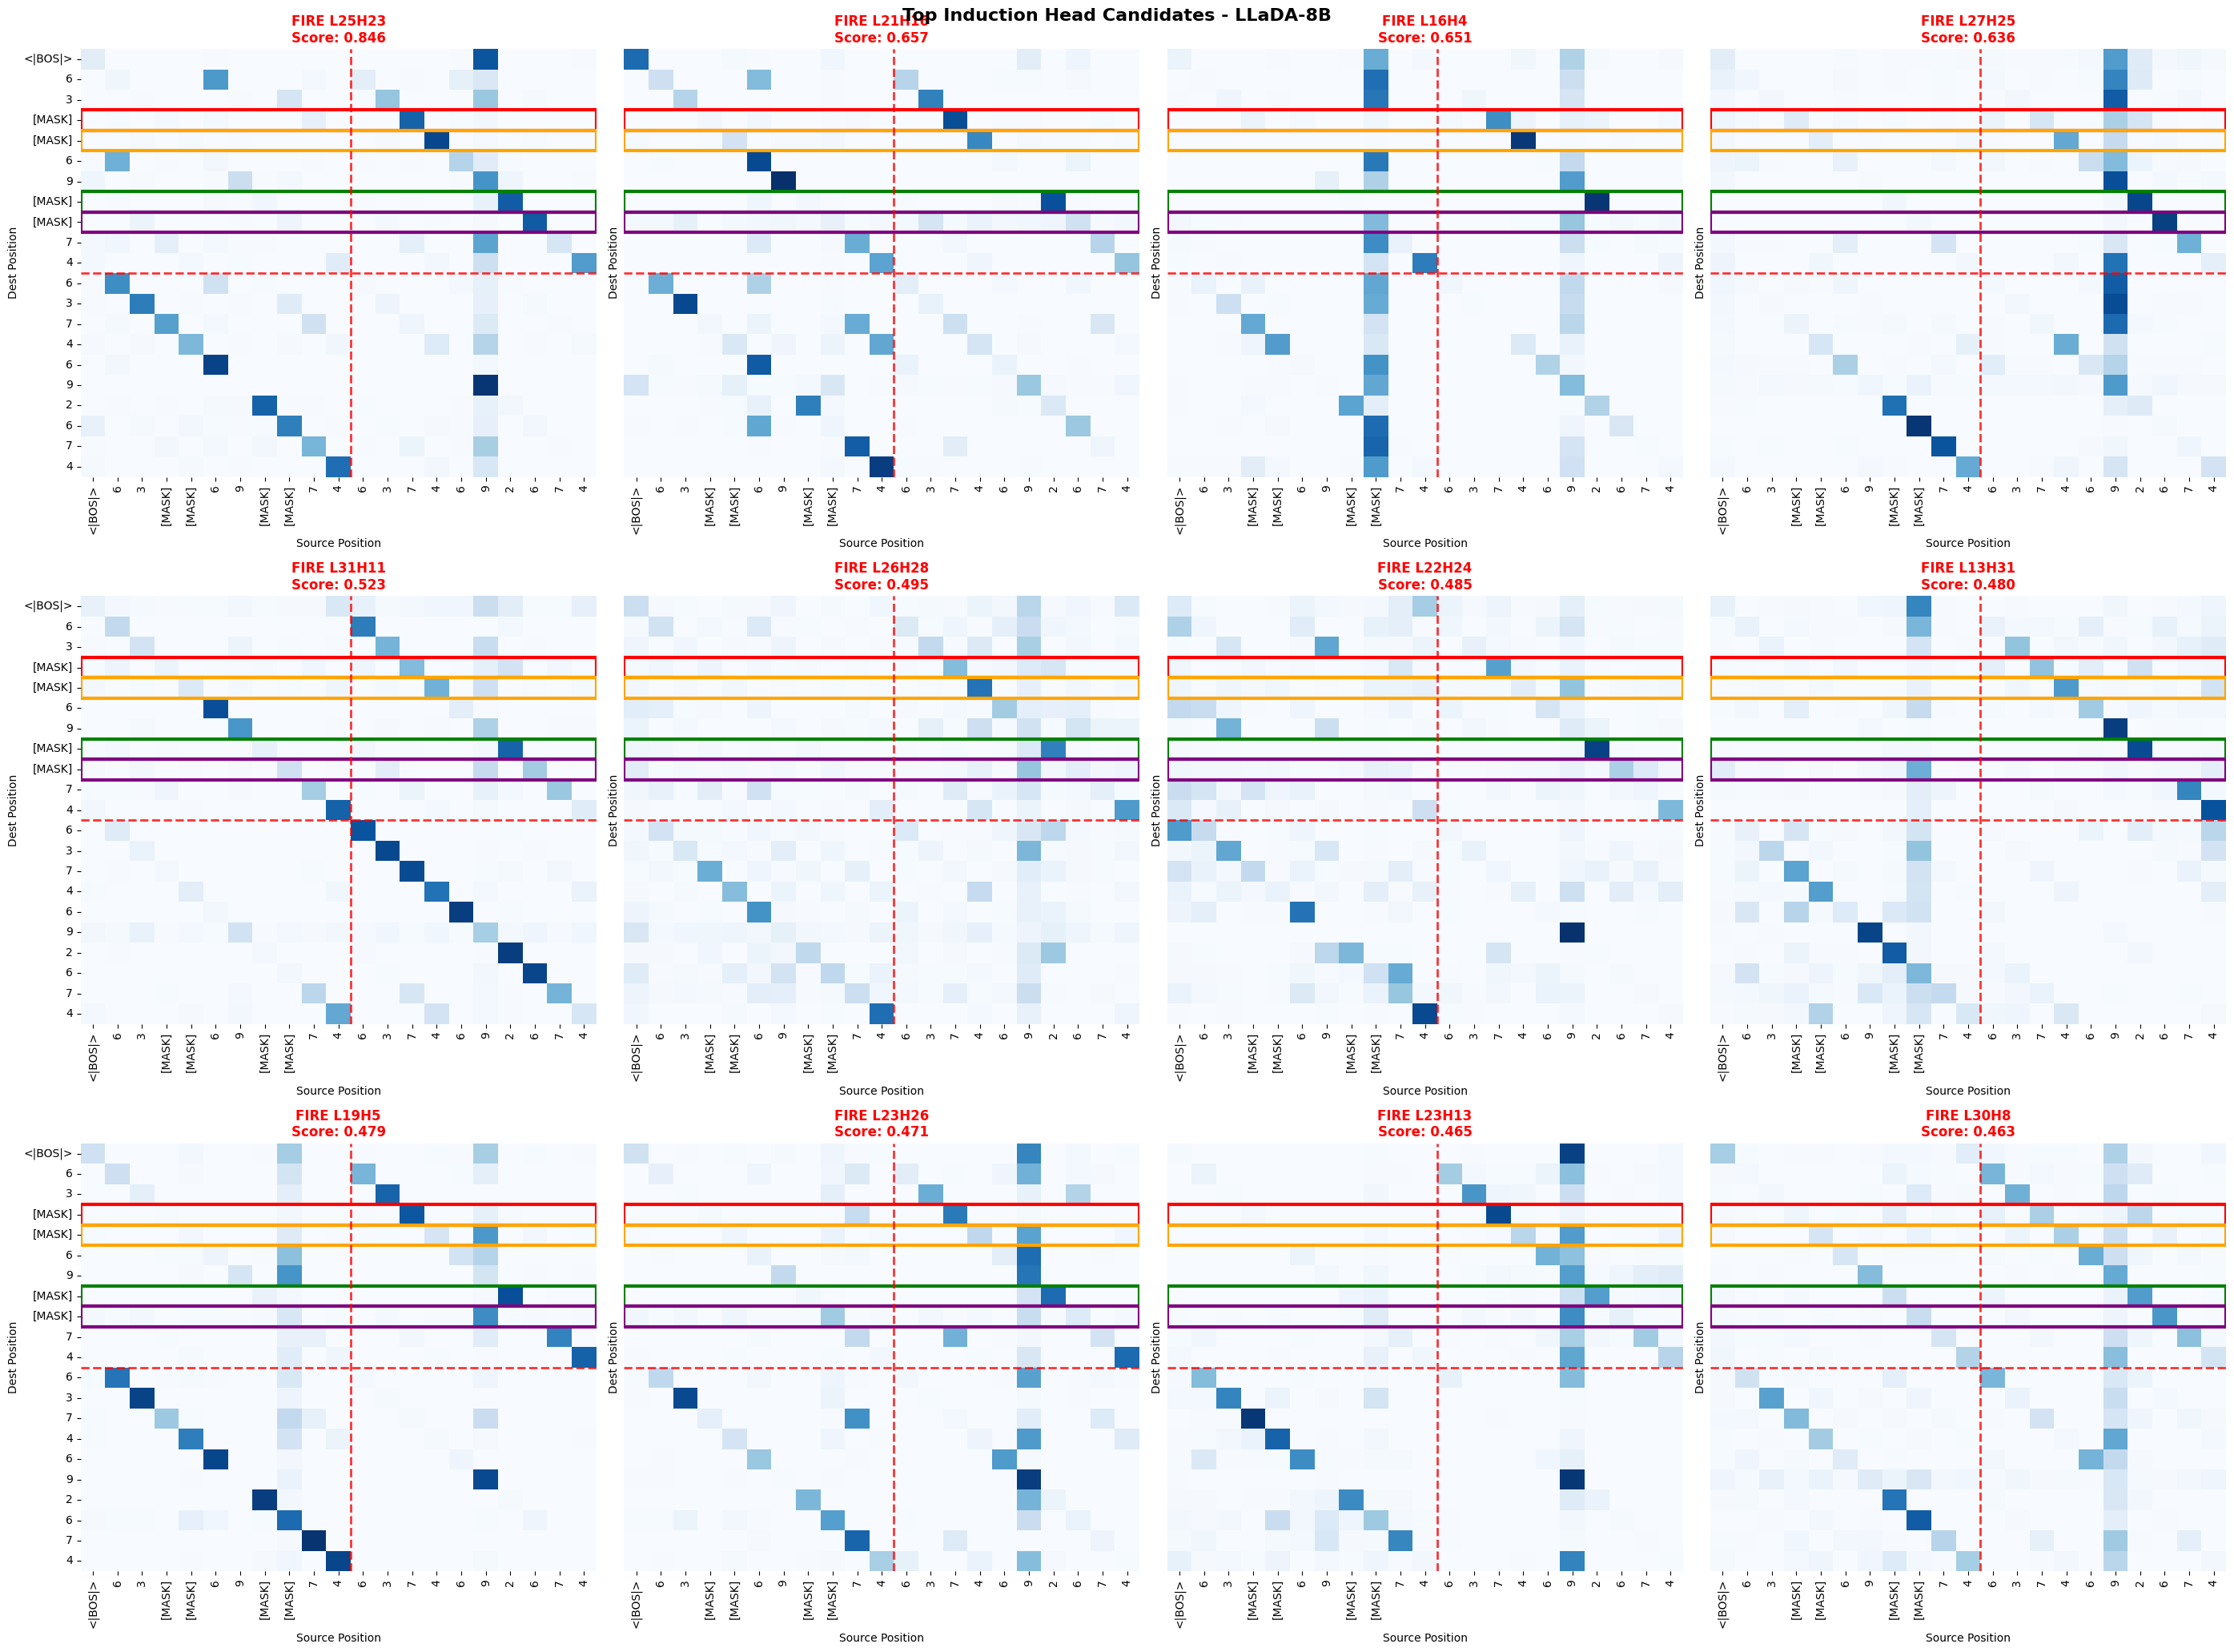


📈 SUMMARY STATISTICS - LLaDA-8B INDUCTION HEADS
📊 SCORE DISTRIBUTION:
   🔥 Strong heads (>0.1):      76 (7.4%)
   ⚡ Moderate heads (0.05-0.1): 117 (11.4%)
   ❌ Weak heads (≤0.05):       831 (81.2%)

📈 STATISTICAL SUMMARY:
   Mean score:    0.0408
   Median score:  0.0195
   Std dev:       0.0777
   Max score:     0.8456
   Min score:     0.0000

🏗️ TOP HEADS BY LAYER (Top 20):
   Layer  7:  1 heads ( 5.0%) █
   Layer 10:  1 heads ( 5.0%) █
   Layer 12:  1 heads ( 5.0%) █
   Layer 13:  1 heads ( 5.0%) █
   Layer 16:  1 heads ( 5.0%) █
   Layer 19:  1 heads ( 5.0%) █
   Layer 21:  1 heads ( 5.0%) █
   Layer 22:  1 heads ( 5.0%) █
   Layer 23:  2 heads (10.0%) ██
   Layer 24:  1 heads ( 5.0%) █
   Layer 25:  2 heads (10.0%) ██
   Layer 26:  2 heads (10.0%) ██
   Layer 27:  1 heads ( 5.0%) █
   Layer 29:  2 heads (10.0%) ██
   Layer 30:  1 heads ( 5.0%) █
   Layer 31:  1 heads ( 5.0%) █

🎉 LLaDA ANALYSIS COMPLETE!
   ✓ Analyzed 1024 attention heads across 32 layers
   ✓ Found 76 strong in

In [8]:
##%%
# Extract attention patterns using our modular function
for mode in ["exact"]:
    print("\n" + "=" * 80)  
    print(f"🎯 EXTRACTING ATTENTION PATTERNS FROM LLaDA in {mode} mode...")
    print("=" * 80)
    
    print("Running attention extraction with validation...")
    
    attention_patterns, validation_results = extract_llada_attention_patterns(
        model, input_ids, validation_mode=True
    )
    
    print(f"✓ Extracted attention patterns: {attention_patterns.shape}")
    
    # Check validation results
    print(f"\n🔍 VALIDATION RESULTS:")
    all_passed = True
    for layer_idx, results in validation_results.items():
        status = "✅ PASS" if results['passed'] else "❌ FAIL"
        print(f"   Layer {layer_idx:2d}: MAE={results['mae']:.2e}, Max={results['max_diff']:.2e} {status}")
        if not results['passed']:
            all_passed = False
    
    if all_passed:
        print("🎉 All layers passed validation - attention extraction is accurate!")
    else:
        print("⚠️  Some layers failed validation - check extraction logic")
    
    ##%%
    # Run the same induction head analysis as LLaMA
    print("\n" + "=" * 80)  
    print("🎯 PRECISION INDUCTION HEAD ANALYSIS - LLaDA-8B")
    print("=" * 80)
    
    # Convert to CPU for analysis
    token_ids = input_ids[0].cpu()
    
    # Analyze all heads with the precision scoring (reusing LLaMA function)
    ranked_heads = analyze_all_heads_induction(attention_patterns, token_ids, token_strings, mode=mode, masked_positions=actual_masked_positions)
    
    print(f"\n🏆 TOP 20 INDUCTION HEADS (by precision score):")
    print("   Rank | Layer | Head | Score | Interpretation")
    print("   -----|-------|------|-------|---------------")
    
    for i, (layer, head, score) in enumerate(ranked_heads[:20]):
        if score > 0.2:
            strength = "🔥 EXCELLENT"
        elif score > 0.1:
            strength = "💪 STRONG  "  
        elif score > 0.05:
            strength = "⚡ MODERATE"
        else:
            strength = "❌ WEAK    "
        
        print(f"   {i+1:2d}.   |  {layer:2d}  |  {head:2d}  | {score:.3f} | {strength}")
    
    ##%%
    # Detailed analysis of top 3 heads (reusing LLaMA function)
    print(f"\n🔍 DETAILED ANALYSIS OF TOP 3 HEADS:")
    print("=" * 60)
    
    for i, (layer, head, score) in enumerate(ranked_heads[:3]):
        print(f"\n🎯 RANK {i+1}: Layer {layer}, Head {head} (Score: {score:.3f})")
        print("-" * 50)
        
        # Get attention pattern
        pattern = attention_patterns[layer, 0, head, :, :].cpu()
        
        # Detailed analysis
        compute_induction_score(pattern, token_ids, mode=mode)
        
        # Additional insights
        seq_mid = len(token_strings) // 2
        cross_attention = pattern[seq_mid:, :seq_mid].mean().item()
        max_attention = pattern.max().item()
        
        print(f"   📈 Cross-sequence attention: {cross_attention:.3f}")
        print(f"   📈 Maximum attention weight: {max_attention:.3f}")
    
    ##%%
    # Plot top 12 induction head candidates (reusing LLaMA function)
    print("\n📊 PLOTTING TOP 12 INDUCTION HEAD CANDIDATES")
    print("=" * 60)
    
    plot_top_induction_heads(ranked_heads, attention_patterns, token_strings, n_plots=12, masked_positions=actual_masked_positions)
    
    ##%%
    # Summary statistics (reusing LLaMA logic)
    print("\n" + "=" * 80)
    print("📈 SUMMARY STATISTICS - LLaDA-8B INDUCTION HEADS")
    print("=" * 80)
    
    # Score distribution analysis
    all_scores = [score for _, _, score in ranked_heads]
    strong_heads = [score for score in all_scores if score > 0.1]
    moderate_heads = [score for score in all_scores if 0.05 < score <= 0.1]
    weak_heads = [score for score in all_scores if score <= 0.05]
    
    print(f"📊 SCORE DISTRIBUTION:")
    print(f"   🔥 Strong heads (>0.1):     {len(strong_heads):3d} ({len(strong_heads)/len(all_scores)*100:.1f}%)")
    print(f"   ⚡ Moderate heads (0.05-0.1): {len(moderate_heads):3d} ({len(moderate_heads)/len(all_scores)*100:.1f}%)")
    print(f"   ❌ Weak heads (≤0.05):       {len(weak_heads):3d} ({len(weak_heads)/len(all_scores)*100:.1f}%)")
    
    print(f"\n📈 STATISTICAL SUMMARY:")
    print(f"   Mean score:    {np.mean(all_scores):.4f}")
    print(f"   Median score:  {np.median(all_scores):.4f}")
    print(f"   Std dev:       {np.std(all_scores):.4f}")
    print(f"   Max score:     {np.max(all_scores):.4f}")
    print(f"   Min score:     {np.min(all_scores):.4f}")
    
    # Layer distribution of top heads
    print(f"\n🏗️ TOP HEADS BY LAYER (Top 20):")
    layer_counts = {}
    for layer, head, score in ranked_heads[:20]:
        layer_counts[layer] = layer_counts.get(layer, 0) + 1
    
    for layer in sorted(layer_counts.keys()):
        count = layer_counts[layer]
        percentage = count / 20 * 100
        bar = "█" * max(1, count)
        print(f"   Layer {layer:2d}: {count:2d} heads ({percentage:4.1f}%) {bar}")
    
    print(f"\n🎉 LLaDA ANALYSIS COMPLETE!")
    print(f"   ✓ Analyzed {len(all_scores)} attention heads across {len(model.model.transformer.blocks)} layers")
    print(f"   ✓ Found {len(strong_heads)} strong induction head candidates")
    print(f"   ✓ Ready for comparison with LLaMA-8B results!")


In [9]:
import torch
import torch.nn.functional as F
from contextlib import contextmanager
from collections import defaultdict

class VHeadAblator:
    """
    Zeroes out V-channels corresponding to selected (layer, head) pairs.
    Works for standard MHSA and GQA/MQA (maps Q head -> KV head as needed).
    """
    def __init__(self, model, heads_to_ablate):
        """
        heads_to_ablate: Iterable[(layer_idx:int, head_idx:int)]
        """
        self.model = model
        self.to_ablate = defaultdict(set)
        for L, H in heads_to_ablate:
            self.to_ablate[L].add(H)
        self._orig_forwards = {}
        self._masks = {}

    def _build_mask(self, block):
        C = block.v_proj.out_features            # d_model
        nH = block.config.n_heads
        nKV = getattr(block.config, "effective_n_kv_heads", nH)
        hd = C // nH                              # per Q head dim (also used for KV slices)
        mask = torch.ones(C, device=block.v_proj.weight.device, dtype=torch.float32)
        for head_idx in self.to_ablate[block.layer_index]:
            if nKV == nH:
                s = slice(head_idx * hd, (head_idx + 1) * hd)
            else:
                rep = nH // nKV
                kv_idx = head_idx // rep
                s = slice(kv_idx * hd, (kv_idx + 1) * hd)
            mask[s] = 0.0
        return mask

    def enable(self):
        """
        Monkey-patches v_proj.forward for targeted layers to apply a channel mask.
        """
        for L, block in enumerate(self.model.model.transformer.blocks):
            block.layer_index = L  # tag for mapping
            if L not in self.to_ablate:
                continue

            # Build and cache mask (kept in fp32; cast on use)
            mask = self._build_mask(block)
            self._masks[L] = mask

            lin = block.v_proj
            if id(lin) in self._orig_forwards:
                continue  # already patched

            orig_forward = lin.forward
            self._orig_forwards[id(lin)] = (lin, orig_forward, L)

            def wrapped_forward(x, _orig=orig_forward, _L=L, _lin=lin):
                out = _orig(x)  # (B, T, C)
                m = self._masks[_L].to(device=out.device, dtype=out.dtype)
                return out * m  # zero chosen channels
            lin.forward = wrapped_forward

    def disable(self):
        """Restore original forwards."""
        for lin_id, (lin, orig_forward, _) in self._orig_forwards.items():
            lin.forward = orig_forward
        self._orig_forwards.clear()
        self._masks.clear()

    @contextmanager
    def active(self):
        try:
            self.enable()
            yield
        finally:
            self.disable()

def validate_v_head_ablation(model, input_ids, layer_idx, head_idxs):
    """
    Validates that zeroing V-channels for (layer_idx, head_idxs) matches
    an explicit manual zeroing of that head in the attention computation.

    Compares:
      - y_manual: attn_out( merge_heads( softmax(QK^T/s)*V_zeroed ) )
      - y_patched: attn_out output captured from the patched model run
    Also prints per-head norms of the pre-attn_out tensor to show the head is zeroed.
    """
    model.eval()

    block = model.model.transformer.blocks[layer_idx]
    config = block.config

    captured = {}

    def cap(name):
        return lambda m, i, o: captured.setdefault(name, o.detach())

    # --- Unpatched run: capture q/k/v, attention_bias, and y_in_ref/y_out_ref ---
    hooks = []
    hooks += [block.q_proj.register_forward_hook(cap('q'))]
    hooks += [block.k_proj.register_forward_hook(cap('k'))]
    hooks += [block.v_proj.register_forward_hook(cap('v'))]
    hooks += [block.register_forward_hook(lambda m, i, o:
        captured.setdefault('attention_bias', (i[1].detach()
                    if len(i) > 1 and isinstance(i[1], torch.Tensor) else None)))]
    hooks += [block.attn_out.register_forward_pre_hook(lambda m, i:
        captured.setdefault('y_in_ref', i[0].detach()))]
    hooks += [block.attn_out.register_forward_hook(cap('y_out_ref'))]

    with torch.inference_mode():
        _ = model(input_ids)

    for h in hooks: h.remove()

    # --- Manual compute with head ablation on V ---
    q, k, v = captured['q'], captured['k'], captured['v']   # (B, T, C)
    B, T, C = q.shape
    H = config.n_heads
    HKV = getattr(config, "effective_n_kv_heads", H)
    hd = C // H

    qh = q.view(B, T, H, hd).transpose(1, 2)                # (B, H, T, hd)
    kh = k.view(B, T, HKV, hd).transpose(1, 2)              # (B, HKV, T, hd)
    vh = v.view(B, T, HKV, hd).transpose(1, 2)              # (B, HKV, T, hd)

    # RoPE
    if getattr(config, "rope", True):
        qh, kh = block.rotary_emb(qh, kh)

    # Map Q-head -> KV-head if needed
    def kv_index_for(q_head_idx):
        if HKV == H:
            return q_head_idx
        rep = H // HKV
        return q_head_idx // rep

    # Zero chosen heads in V (converted to KV indices if needed)
    kv_to_zero = sorted({kv_index_for(h) for h in head_idxs})
    for kvh in kv_to_zero:
        vh[:, kvh, :, :] = 0

    # If HKV < H, repeat k/v across heads to match q (as the model does)
    if HKV != H:
        rep = H // HKV
        kh = kh.repeat_interleave(rep, dim=1)
        vh = vh.repeat_interleave(rep, dim=1)

    bias = captured.get('attention_bias')
    if bias is not None:
        qlen, klen = qh.shape[-2], kh.shape[-2]
        bias = block._cast_attn_bias(bias[:, :, klen - qlen : klen, :klen], kh.dtype)

    scores = (qh @ kh.transpose(-2, -1)) * (qh.shape[-1] ** -0.5)
    if bias is not None:
        scores = scores + bias
    w = torch.softmax(scores, dim=-1)
    ctx = w @ vh                                            # (B, H, T, hd)

    y_in_manual = ctx.transpose(1, 2).contiguous().view(B, T, C)  # merge heads
    with torch.autocast('cuda', dtype=q.dtype) if q.is_cuda else torch.cuda.amp.autocast(enabled=False):
        y_out_manual = block.attn_out(y_in_manual)

    # --- Patched run: capture y_in/y_out with real-time ablation on v_proj ---
    y_cap = {}
    hpre = block.attn_out.register_forward_pre_hook(lambda m, i: y_cap.setdefault('y_in_patched', i[0].detach()))
    hout = block.attn_out.register_forward_hook(lambda m, i, o: y_cap.setdefault('y_out_patched', o.detach()))

    ablator = VHeadAblator(model, [(layer_idx, h) for h in head_idxs])
    with ablator.active(), torch.inference_mode():
        _ = model(input_ids)

    hpre.remove(); hout.remove()

    # --- Compare post-projection outputs ---
    y_ref = y_cap['y_out_patched']
    mae = (y_ref - y_out_manual).abs().mean().item()
    mx  = (y_ref - y_out_manual).abs().max().item()

    print(f"[Layer {layer_idx} | heads {head_idxs}] post-proj MAE={mae:.3e} max={mx:.3e}")

    # --- Minimal visualization: per-head norm at pre-attn_out (should be ~0 for ablated heads) ---
    def head_norms(y_in):
        # y_in: (B, T, C) -> (B, H, T, hd) -> L2 over (T, hd)
        y = y_in.view(B, T, H, hd).transpose(1, 2).contiguous()   # (B, H, T, hd)
        return y.float().pow(2).sum(dim=(-1,-2)).sqrt().squeeze(0)  # (H,)
    hn_ref     = head_norms(captured['y_in_ref'])
    hn_manual  = head_norms(y_in_manual)
    hn_patched = head_norms(y_cap['y_in_patched'])

    # print a few heads around the ablated ones
    to_show = sorted(set(head_idxs) | {max(0, min(head_idxs)-1), min(H-1, max(head_idxs)+1)})
    rows = []
    for h in to_show:
        rows.append(f" head {h:02d}  pre_ref={hn_ref[h]:.3e}  manual={hn_manual[h]:.3e}  patched={hn_patched[h]:.3e}")
    print("Per-head ||y_in|| (L2):\n" + "\n".join(rows))

    return {
        "mae": mae,
        "max": mx,
        "y_out_manual": y_out_manual,
        "y_out_patched": y_ref,
        "y_in_manual": y_in_manual,
        "y_in_patched": y_cap['y_in_patched'],
        "head_norms": {"ref": hn_ref, "manual": hn_manual, "patched": hn_patched},
    }



with torch.inference_mode():
    # Example: ablate head 7 in layer 0
    res = validate_v_head_ablation(model, input_ids, layer_idx=0, head_idxs=[7])

    # Example: ablate multiple heads in a single layer
    res = validate_v_head_ablation(model, input_ids, layer_idx=16, head_idxs=[4,5,11])

[Layer 0 | heads [7]] post-proj MAE=2.655e-08 max=5.722e-06
Per-head ||y_in|| (L2):
 head 06  pre_ref=2.069e+00  manual=2.069e+00  patched=2.069e+00
 head 07  pre_ref=3.961e+00  manual=0.000e+00  patched=0.000e+00
 head 08  pre_ref=5.578e+00  manual=5.578e+00  patched=5.578e+00
[Layer 16 | heads [4, 5, 11]] post-proj MAE=3.052e-07 max=1.431e-05
Per-head ||y_in|| (L2):
 head 03  pre_ref=1.495e+01  manual=1.495e+01  patched=1.495e+01
 head 04  pre_ref=2.148e+01  manual=0.000e+00  patched=0.000e+00
 head 05  pre_ref=1.057e+01  manual=0.000e+00  patched=0.000e+00
 head 11  pre_ref=2.956e+01  manual=0.000e+00  patched=0.000e+00
 head 12  pre_ref=8.324e+00  manual=8.324e+00  patched=8.324e+00


In [14]:
# RRT (Repeated Random Tokens) Induction Head Discovery System — Refactored for V-Ablation
# Uses a shared ablation mechanism for both experimentation and validation.

import traceback
import numpy as np
import torch
import torch.nn.functional as F
from typing import List, Tuple, Dict, Optional, Union, Any, Iterable
import random
from dataclasses import dataclass
from tqdm import tqdm
import gc
from contextlib import contextmanager
from collections import defaultdict

# =========================================
# =============== Config ==================
# =========================================

@dataclass
class RRTConfig:
    n_sequences: int = 200
    base_sequence_length: int = 50
    vocab_size: int = 50
    mask_ratio: float = 0.2
    first_half_mask_ratio: float = 0.5
    batch_size: int = 16
    random_seed: int = 42

@dataclass
class RRTSample:
    """One RRT example with explicit targets for masked positions."""
    input_ids: torch.Tensor           # (1, T)
    mask_indices: torch.Tensor        # (T,) bool
    token_strings: List[str]
    masked_positions: List[int]
    targets: torch.Tensor             # (1, T) int64; -100 where not masked

@dataclass
class InductionResults:
    head_scores: List[Tuple[int, int, float, float]]  # (layer, head, prev, next)
    sequence_scores: Dict[int, Dict[Tuple[int, int], Tuple[float, float]]]
    config: RRTConfig

# =========================================
# ========= Utility / Environment =========
# =========================================

def get_device(model) -> torch.device:
    return next(model.parameters()).device

def _normalize_rrt_item(
    item: Union[RRTSample, Tuple[torch.Tensor, torch.Tensor, List[str], List[int]]]
) -> Tuple[torch.Tensor, torch.Tensor, List[str], List[int], Optional[torch.Tensor]]:
    """
    Returns (input_ids, mask_indices, token_strings, masked_positions, targets_or_None)
    for both the new RRTSample and the legacy 4-tuple.
    """
    if isinstance(item, RRTSample):
        return item.input_ids, item.mask_indices, item.token_strings, item.masked_positions, item.targets
    else:
        # legacy: (input_ids, mask_indices, token_strings, masked_positions)
        input_ids, mask_indices, token_strings, masked_positions = item
        return input_ids, mask_indices, token_strings, masked_positions, None

# =========================================
# ===== RRT sequence generation (as-is) ===
# =========================================


class RRTSequenceGenerator:
    def __init__(self, config: RRTConfig):
        self.config = config
        np.random.seed(config.random_seed)
        random.seed(config.random_seed)

    def generate_rrt_sequences(self, tokenizer) -> List[RRTSample]:
        """
        Generate RRT sequences and return a list of RRTSample with explicit targets.

        targets: true token id for every masked position; -100 elsewhere.
        NOTE: We never use the mask token id as a target.
        """
        sequences: List[RRTSample] = []

        print(f"Generating {self.config.n_sequences} RRT sequences...")
        print(f"Base sequence length: {self.config.base_sequence_length}")
        print(f"Total sequence length: {self.config.base_sequence_length * 2}")
        print(f"Vocabulary size: {self.config.vocab_size}")
        print(f"Mask ratio: {self.config.mask_ratio}")

        vocab_tokens = self._get_safe_vocab_tokens(tokenizer)
        mask_token_id = 126336

        for seq_idx in tqdm(range(self.config.n_sequences), desc="Generating sequences"):
            # 1) Build the repeated sequence BEFORE masking
            base = np.random.choice(vocab_tokens, self.config.base_sequence_length)
            full = np.concatenate([base, base]).tolist()    # length = 2L
            L = self.config.base_sequence_length

            # 2) Tokenize and build string render
            input_ids = torch.tensor([[tokenizer.bos_token_id] + full], dtype=torch.long)  # (1, 2L+1)
            token_strings = ['<|BOS|>'] + [tokenizer.decode([t]) for t in full]

            # 3) Decide which half to mask
            mask_first_half = seq_idx < (self.config.n_sequences * self.config.first_half_mask_ratio)
            if mask_first_half:
                mask_region = list(range(1, 1 + L))        # first half (skip BOS)
            else:
                mask_region = list(range(1 + L, 1 + 2 * L)) # second half

            n_to_mask = max(1, int(len(mask_region) * self.config.mask_ratio))
            masked_positions = sorted(random.sample(mask_region, n_to_mask))

            # 4) Build targets BEFORE mutating input_ids
            targets = torch.full_like(input_ids, fill_value=-100)  # (1, 2L+1)
            for pos in masked_positions:
                if mask_first_half:
                    # True label is the original first-half token at pos
                    targets[0, pos] = input_ids[0, pos].item()
                else:
                    # Masking the second half: target is corresponding first-half token
                    first_pos = pos - L
                    targets[0, pos] = input_ids[0, first_pos].item()

            # safety: make sure we never set the mask token as a target
            assert all(t != mask_token_id for t in targets[0, masked_positions]), "MASK id leaked into targets!"

            # 5) Apply masking to the INPUT (not the target)
            for pos in masked_positions:
                input_ids[0, pos] = mask_token_id
                token_strings[pos] = '[MASK]'

            # 6) Build mask_indices
            mask_indices = torch.zeros_like(input_ids[0], dtype=torch.bool)
            mask_indices[masked_positions] = True

            sequences.append(
                RRTSample(
                    input_ids=input_ids,
                    mask_indices=mask_indices,
                    token_strings=token_strings,
                    masked_positions=masked_positions,
                    targets=targets
                )
            )

        print(f"Generated {len(sequences)} RRT sequences")
        return sequences

    def _get_safe_vocab_tokens(self, tokenizer) -> np.ndarray:
        vocab_size = len(tokenizer.vocab) if hasattr(tokenizer, 'vocab') else tokenizer.vocab_size
        safe_tokens = []
        for token_id in range(vocab_size):
            try:
                token_str = tokenizer.decode([token_id])
                if (token_id not in tokenizer.all_special_ids and
                    len(token_str.strip()) > 0 and
                    len(token_str) <= 10):
                    safe_tokens.append(token_id)
                if len(safe_tokens) >= self.config.vocab_size:
                    break
            except:
                continue

        if len(safe_tokens) < self.config.vocab_size:
            print(f"Warning: Only found {len(safe_tokens)} safe tokens, using all of them")

        return np.array(safe_tokens[:self.config.vocab_size])

    def _create_masked_rrt_sequence(self, tokenizer, digit_sequence: np.ndarray, mask_first_half: bool) \
            -> Tuple[torch.Tensor, torch.Tensor, List[str], List[int]]:
        token_ids = digit_sequence.tolist()
        input_ids = torch.tensor([[tokenizer.bos_token_id] + token_ids])
        token_strings = ['<|BOS|>'] + [tokenizer.decode([tid]) for tid in token_ids]
        targets = input_ids.detach().clone()

        total_length = len(digit_sequence)
        half_length = total_length // 2

        if mask_first_half:
            mask_region_start = 1
            mask_region_end = half_length + 1
        else:
            mask_region_start = half_length + 1
            mask_region_end = total_length + 1

        maskable_positions = list(range(mask_region_start, mask_region_end))
        n_to_mask = max(1, int(len(maskable_positions) * self.config.mask_ratio))
        masked_positions = sorted(random.sample(maskable_positions, n_to_mask))

        # NOTE: Adjust [MASK] id to your tokenizer if needed.
        for pos in masked_positions:
            input_ids[0, pos] = 126336
            token_strings[pos] = '[MASK]'

        return input_ids, targets, token_strings, masked_positions

# =========================================
# ===== Induction scoring (as before) =====
# =========================================

class BatchInductionAnalyzer:
    """Analyze induction heads across multiple RRT sequences in batches"""

    def __init__(self, model, tokenizer, config: RRTConfig):
        self.model = model
        self.tokenizer = tokenizer
        self.config = config
        self.device = get_device(model)

    def analyze_sequences_batch(self, sequences) -> InductionResults:
        """
        Accepts either List[RRTSample] (preferred) or legacy List[tuple].
        Now computes prev, next, AND exact scores for each head.
        """
        print(f"\nAnalyzing {len(sequences)} sequences for induction heads...")

        n_layers = len(self.model.model.transformer.blocks)
        n_heads = self.model.model.transformer.blocks[0].config.n_heads

        prev_score_accumulator = torch.zeros(n_layers, n_heads, dtype=torch.float32)
        next_score_accumulator = torch.zeros(n_layers, n_heads, dtype=torch.float32)
        exact_score_accumulator = torch.zeros(n_layers, n_heads, dtype=torch.float32)  # NEW
        valid_sequences = 0
        sequence_scores: Dict[int, Dict[Tuple[int, int], Tuple[float, float, float]]] = {}  # Updated to store 3 scores

        batch_size = min(self.config.batch_size, len(sequences))

        for batch_start in tqdm(range(0, len(sequences), batch_size), desc="Processing batches"):
            batch_end = min(batch_start + batch_size, len(sequences))
            batch_sequences = sequences[batch_start:batch_end]

            for seq_idx, raw_item in enumerate(batch_sequences):
                global_seq_idx = batch_start + seq_idx

                try:
                    input_ids, mask_indices, token_strings, masked_positions, _targets = _normalize_rrt_item(raw_item)

                    attention_patterns = self._extract_attention_patterns(input_ids.to(self.device))
                    sequence_scores[global_seq_idx] = {}

                    token_ids = input_ids[0].cpu()
                    for layer in range(n_layers):
                        for head in range(n_heads):
                            pattern = attention_patterns[layer, 0, head, :, :].cpu()

                            prev_score = compute_induction_score(
                                pattern, token_ids, mode="prev", masked_positions=masked_positions
                            )
                            next_score = compute_induction_score(
                                pattern, token_ids, mode="next", masked_positions=masked_positions
                            )
                            exact_score = compute_induction_score(  # NEW
                                pattern, token_ids, mode="exact", masked_positions=masked_positions
                            )

                            prev_score_accumulator[layer, head] += prev_score
                            next_score_accumulator[layer, head] += next_score
                            exact_score_accumulator[layer, head] += exact_score  # NEW
                            sequence_scores[global_seq_idx][(layer, head)] = (prev_score, next_score, exact_score)  # Updated

                    valid_sequences += 1

                except Exception as e:
                    print(f"Warning: Failed to process sequence {global_seq_idx}: {e}")
                    print(f"Error details:\n{traceback.format_exc()}")
                    continue

                del attention_patterns
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

        if valid_sequences == 0:
            raise ValueError("No sequences were successfully processed!")

        prev_scores = prev_score_accumulator / valid_sequences
        next_scores = next_score_accumulator / valid_sequences
        exact_scores = exact_score_accumulator / valid_sequences  # NEW

        head_scores: List[Tuple[int, int, float, float, float]] = []  # Updated to store 5 values
        for layer in range(n_layers):
            for head in range(n_heads):
                head_scores.append((
                    layer, 
                    head, 
                    prev_scores[layer, head].item(), 
                    next_scores[layer, head].item(),
                    exact_scores[layer, head].item()  # NEW
                ))

        head_scores.sort(key=lambda x: x[2] + x[3] + x[4], reverse=True)  # Sort by combined prev+next+exact

        print(f"\nProcessed {valid_sequences} sequences successfully")
        print(f"Top 10 induction heads (by combined prev+next+exact score):")
        for i, (layer, head, prev_score, next_score, exact_score) in enumerate(head_scores[:10]):  # Updated
            combined = prev_score + next_score + exact_score
            print(f"  {i + 1:2d}. L{layer}H{head}: prev={prev_score:.4f}, next={next_score:.4f}, exact={exact_score:.4f}, combined={combined:.4f}")

        return InductionResults(head_scores=head_scores, sequence_scores=sequence_scores, config=self.config)

    def _extract_attention_patterns(self, input_ids: torch.Tensor) -> torch.Tensor:
        """Extract attention patterns using existing function"""
        input_ids = input_ids.to(self.device)
        # Uses your existing implementation:
        attention_patterns = extract_llada_attention_patterns(self.model, input_ids, validation_mode=False)
        return attention_patterns

# =========================================
# =========== V-Head Ablation =============
# =========================================

@torch.no_grad()
def validate_v_head_ablation_single_layer(model, input_ids, layer_idx: int, head_idxs: List[int]) -> Dict[str, Any]:
    """
    Validates that zeroing V for (layer_idx, head_idxs) matches a manual V=0 attention computation.
    Also prints per-head pre-attn_out norms to show targeted heads are ~0.
    Uses the SAME VHeadAblator used by the experiment (shared code).
    """
    block = model.model.transformer.blocks[layer_idx]
    cfg = block.config

    captured = {}

    def cap(name):
        return lambda m,i,o: captured.setdefault(name, o.detach())

    # First pass (unpatched): capture q,k,v, attention_bias, and pre/post attn_out
    h = []
    h += [block.q_proj.register_forward_hook(cap('q'))]
    h += [block.k_proj.register_forward_hook(cap('k'))]
    h += [block.v_proj.register_forward_hook(cap('v'))]
    h += [block.register_forward_hook(lambda m,i,o: captured.setdefault('attention_bias',
            (i[1].detach() if len(i)>1 and isinstance(i[1], torch.Tensor) else None)))]
    h += [block.attn_out.register_forward_pre_hook(lambda m,i: captured.setdefault('y_in_ref', i[0].detach()))]
    h += [block.attn_out.register_forward_hook(cap('y_out_ref'))]

    _ = model(input_ids.to(get_device(model)))
    for hh in h: hh.remove()

    q, k, v = captured['q'], captured['k'], captured['v']
    B, T, C = q.shape
    H = cfg.n_heads
    Hk = getattr(cfg, 'effective_n_kv_heads', H)
    if Hk != H:
        raise NotImplementedError

    hd = C // H

    qh = q.view(B, T, H, hd).transpose(1, 2)
    kh = k.view(B, T, H, hd).transpose(1, 2)
    vh = v.view(B, T, H, hd).transpose(1, 2)

    qh, kh = block.rotary_emb(qh, kh)

    # Manual: zero V for selected heads
    for kvh in head_idxs:
        vh[:, kvh, :, :] = 0

    if captured.get('attention_bias') is not None:
        raise NotImplementedError

    scores = (qh @ kh.transpose(-2, -1)) * (qh.shape[-1] ** -0.5)
    w = torch.softmax(scores, dim=-1)
    ctx = w @ vh  # (B, H, T, hd)

    y_in_manual = ctx.transpose(1, 2).contiguous().view(B, T, C)
    y_out_manual = block.attn_out(y_in_manual)

    # Patched pass: use the SAME ablator used in experiments
    y_cap = {}
    hpre = block.attn_out.register_forward_pre_hook(lambda m,i: y_cap.setdefault('y_in_patched', i[0].detach()))
    hout = block.attn_out.register_forward_hook(lambda m,i,o: y_cap.setdefault('y_out_patched', o.detach()))
    ablator = VHeadAblator(model, [(layer_idx, h) for h in head_idxs])
    with ablator.active():
        _ = model(input_ids.to(get_device(model)))
    hpre.remove(); hout.remove()

    y_patched = y_cap['y_out_patched']

    mae = (y_patched - y_out_manual).abs().mean().item()
    mx  = (y_patched - y_out_manual).abs().max().item()

    # Minimal visualization: head-wise L2 norms of pre-attn_out
    def head_norms(y_in):
        y = y_in.view(B, T, H, hd).transpose(1, 2)
        return y.float().pow(2).sum(dim=(-1, -2)).sqrt().squeeze(0)  # (H,)
    hn_ref = head_norms(captured['y_in_ref'])
    hn_man = head_norms(y_in_manual)
    hn_pat = head_norms(y_cap['y_in_patched'])

    print(f"[L{layer_idx} heads {head_idxs}] post-proj MAE={mae:.3e} max={mx:.3e}")
    show = sorted(set(head_idxs) | {max(0, min(head_idxs)-1), min(H-1, max(head_idxs)+1)})
    for hq in show:
        print(f"  head {hq:02d}  ||pre_ref||={hn_ref[hq]:.3e}  manual={hn_man[hq]:.3e}  patched={hn_pat[hq]:.3e}")

    return {
        "mae": mae, "max": mx,
        "y_out_manual": y_out_manual, "y_out_patched": y_patched,
        "head_norms": {"ref": hn_ref, "manual": hn_man, "patched": hn_pat}
    }

# =========================================
# ======= Experiment-time Ablation ========
# =========================================

class InductionHeadAblator:
    """
    Thin wrapper around VHeadAblator to evaluate performance with/without ablation.
    No weight surgery; everything is runtime and reversible.
    """
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
        self.device = get_device(model)

    @torch.no_grad()
    def evaluate_mask_prediction_accuracy(self, test_sequences: List[RRTSample]) -> Dict[str, float]:
        """
        Computes accuracy strictly on masked positions using the provided targets.
        Expects RRTSample objects (with targets). If a legacy tuple is passed, raises.
        """
        device = get_device(self.model)

        total = 0
        correct = 0

        for sample in tqdm(test_sequences, desc="Evaluating"):
            try:
                logits = self.model(sample.input_ids.to(device)).logits  # (1, T, V)
                preds = logits.argmax(dim=-1).cpu()                      # (1, T)
                tgt   = sample.targets[0]                                # (T,)

                masked = sample.mask_indices
                p = preds[0][masked]
                g = sample.targets[0][masked]
                total += masked.sum().item()
                correct += (p == g).sum().item()

            except Exception as e:
                print(f"Warning: Failed to evaluate sequence: {e}")
                continue

        acc = (correct / total) if total > 0 else 0.0
        print(f"Mask prediction accuracy: {acc:.4f} ({correct}/{total})")
        return {'accuracy': acc, 'total_masked_tokens': total, 'correct_predictions': correct}

# ===========================
# === Metrics & Utilities ===
# ===========================

from dataclasses import dataclass
from typing import List, Tuple, Dict, Any, Optional
import numpy as np
import torch
import torch.nn.functional as F
import random
from collections import defaultdict

# ---- If not already present in your file ----
def get_device(model) -> torch.device:
    return next(model.parameters()).device

def force_eval_mode(model):
    model.eval()

@dataclass
class AblationRunMetrics:
    # Accuracy
    accuracy: float
    total_masked: int
    # Logits-centric measures (key signal)
    mean_correct_logit_drop: float     # E[ logits_base[true] - logits_abl[true] ] over masked positions
    mean_correct_prob_drop: float      # E[ p_base[true] - p_abl[true] ]
    mean_kl_div: float                 # E[ KL( p_base || p_abl ) ]
    # Optional: you can add more (e.g., margin_drop) later without breaking callers.

def _confidence_interval(values: List[float], alpha: float = 0.05):
    """
    Normal-approx 95% CI (good enough for 5-10 trials).
    Returns (mean, lo, hi). If empty, returns (nan, nan, nan).
    """
    if len(values) == 0:
        return float('nan'), float('nan'), float('nan')
    arr = np.array(values, dtype=np.float64)
    mean = float(arr.mean())
    if len(values) == 1:
        return mean, mean, mean
    se = float(arr.std(ddof=1) / np.sqrt(len(values)))
    z = 1.96  # ~95%
    return mean, mean - z*se, mean + z*se

def select_top_heads(induction_results, top_k: int, mode: str = "combined") -> List[Tuple[int,int]]:
    """
    Updated to handle exact scores. 
    mode in {"combined", "prev", "next", "exact"}; returns top_k (layer, head).
    """
    rows = induction_results.head_scores  # (layer, head, prev, next, exact)
    if mode == "combined":
        scored = sorted(rows, key=lambda r: (r[2] + r[3] + r[4]), reverse=True)  # prev + next + exact
    elif mode == "prev":
        scored = sorted(rows, key=lambda r: r[2], reverse=True)
    elif mode == "next":
        scored = sorted(rows, key=lambda r: r[3], reverse=True)
    elif mode == "exact":  # NEW
        scored = sorted(rows, key=lambda r: r[4], reverse=True)
    else:
        raise ValueError(f"Unknown mode {mode}")
    return [(L, H) for (L, H, _, _, _) in scored[:top_k]]


def sample_random_heads(model, num_heads: int, exclude_first_n_layers: int = 0,
                        allowed_layers: Optional[List[int]] = None,
                        seed: Optional[int] = None) -> List[Tuple[int,int]]:
    """
    Uniformly sample unique (layer, head) pairs.
    - If allowed_layers is None, uses [exclude_first_n_layers, ..., n_layers-1].
    - Matches global head space; no weighting by layer.
    """
    if seed is not None:
        random.seed(seed)
    blocks = model.model.transformer.blocks
    n_layers = len(blocks)
    n_heads = blocks[0].config.n_heads

    if allowed_layers is None:
        allowed_layers = list(range(exclude_first_n_layers, n_layers))
    universe = [(L, h) for L in allowed_layers for h in range(n_heads)]
    if num_heads > len(universe):
        raise ValueError("num_heads exceeds number of available heads in allowed layer range")

    return random.sample(universe, num_heads)

# ===============================
# === Core eval (logits-first) ===
# ===============================

@torch.no_grad()
def _evaluate_sequences_logits(
    model,
    sequences,
    heads_to_ablate: Optional[List[Tuple[int,int]]] = None,
) -> AblationRunMetrics:
    """
    Compute accuracy and logits metrics over masked positions.
    If heads_to_ablate is provided, compares ablated vs baseline logits per sample.
    Accuracy is computed from the *run's own* predictions:
      - baseline call (heads_to_ablate=None): uses baseline logits
      - ablated  call (heads_to_ablate=...): uses ablated  logits
    """
    device = get_device(model)
    force_eval_mode(model)

    total_masked = 0
    correct = 0

    sum_d_logit_true = 0.0
    sum_d_prob_true  = 0.0
    sum_kl           = 0.0

    for sample in sequences:
        # Unpack sample robustly
        input_ids, mask_indices, token_strings, masked_positions = sample.input_ids, sample.mask_indices, sample.token_strings, sample.masked_positions
        input_ids = input_ids.to(device)

        # --- Baseline (no ablation) ---
        out_base = model(input_ids)
        logits_base = out_base.logits[0]  # (T, V)

        # --- Ablated (if requested) ---
        if heads_to_ablate:
            with VHeadAblator(model, heads_to_ablate).active():
                out_ab = model(input_ids)
                logits_ab = out_ab.logits[0]
        else:
            logits_ab = logits_base  # no-ablation case

        # Choose which logits to use for *accuracy* for this run
        logits_for_accuracy = logits_ab if heads_to_ablate else logits_base

        # Reconstruct ground-truth tokens (RRT-specific)
        seq_len  = input_ids.shape[1] - 1  # exclude BOS
        half_len = seq_len // 2
        ground_truth = []
        for pos in range(input_ids.shape[1]):
            if pos == 0:
                ground_truth.append(input_ids[0, pos].item())
            elif pos <= half_len:
                ground_truth.append(input_ids[0, pos].item())
            else:
                ground_truth.append(input_ids[0, pos - half_len].item())

        # Metrics over masked positions
        for pos in masked_positions:
            total_masked += 1
            true_tok = ground_truth[pos]

            # Accuracy (for this run)
            pred_tok = int(torch.argmax(logits_for_accuracy[pos]))
            if pred_tok == true_tok:
                correct += 1

            # Logits/probs deltas (always baseline vs ablated)
            lb = logits_base[pos].float()
            la = logits_ab[pos].float()

            # correct-token logit drop
            sum_d_logit_true += float(lb[true_tok].item() - la[true_tok].item())

            # probability drop for the true token
            pb = F.softmax(lb, dim=-1)
            pa = F.softmax(la, dim=-1)
            sum_d_prob_true += float(pb[true_tok].item() - pa[true_tok].item())

            # KL(base || ablated)
            eps = 1e-8
            kl = (pb * (torch.log(pb + eps) - torch.log(pa + eps))).sum().item()
            sum_kl += float(kl)

    accuracy = (correct / total_masked) if total_masked > 0 else 0.0
    mean_d_logit = (sum_d_logit_true / total_masked) if total_masked > 0 else 0.0
    mean_d_prob  = (sum_d_prob_true  / total_masked) if total_masked > 0 else 0.0
    mean_kl      = (sum_kl           / total_masked) if total_masked > 0 else 0.0

    return AblationRunMetrics(
        accuracy=accuracy,
        total_masked=total_masked,
        mean_correct_logit_drop=mean_d_logit,
        mean_correct_prob_drop=mean_d_prob,
        mean_kl_div=mean_kl,
    )

# =========================
# === Bootstrap runner  ===
# =========================

from contextlib import nullcontext

def run_single_ablation_eval(model, sequences, heads: List[Tuple[int,int]]):
    """
    Convenience wrapper: returns (metrics_baseline, metrics_ablated)
    """
    # Baseline (no ablation); we measure accuracy and set deltas ~ 0
    baseline = _evaluate_sequences_logits(model, sequences, heads_to_ablate=None)
    # Ablated run with specified heads
    ablated  = _evaluate_sequences_logits(model, sequences, heads_to_ablate=heads)
    return baseline, ablated

def bootstrap_random_head_ablation(
    model,
    sequences,
    num_trials: int,
    num_heads_per_trial: int,
    exclude_first_n_layers: int = 0,
    allowed_layers: Optional[List[int]] = None,
    seed: Optional[int] = None,
):
    """
    Runs N random ablation trials; each trial ablates `num_heads_per_trial` heads.
    Returns:
      {
        'trials': [ {'heads': [...], 'ablated': AblationRunMetrics}, ... ],
        'aggregate': { per-metric mean & CI },
        'config': {...}
      }
    """
    blocks = model.model.transformer.blocks
    n_layers = len(blocks)
    n_heads  = blocks[0].config.n_heads

    trials = []
    metric_acc   = []
    metric_dlog  = []
    metric_dprob = []
    metric_kl    = []

    for t in range(num_trials):
        # sample heads (unique pairs)
        heads = sample_random_heads(
            model,
            num_heads=num_heads_per_trial,
            exclude_first_n_layers=exclude_first_n_layers,
            allowed_layers=allowed_layers,
            seed=(None if seed is None else seed + t),
        )
        # run ablated evaluation (baseline not needed here, we compare absolute means)
        _, abl = run_single_ablation_eval(model, sequences, heads)
        trials.append({'heads': heads, 'ablated': abl})

        metric_acc.append(abl.accuracy)
        metric_dlog.append(abl.mean_correct_logit_drop)
        metric_dprob.append(abl.mean_correct_prob_drop)
        metric_kl.append(abl.mean_kl_div)

    agg = {
        'accuracy':            {'mean': _confidence_interval(metric_acc)},
        'correct_logit_drop':  {'mean': _confidence_interval(metric_dlog)},
        'correct_prob_drop':   {'mean': _confidence_interval(metric_dprob)},
        'kl_div':              {'mean': _confidence_interval(metric_kl)},
    }

    return {
        'trials': trials,
        'aggregate': agg,
        'config': {
            'num_trials': num_trials,
            'num_heads_per_trial': num_heads_per_trial,
            'exclude_first_n_layers': exclude_first_n_layers,
            'allowed_layers': allowed_layers,
        }
    }

# =========================
# === High-level Runner ===
# =========================

def run_ablation_suite(
    model,
    induction_results,
    val_sequences,
    top_k: int = 10,
    random_trials: int = 10,
    exclude_first_n_layers: int = 4,
):
    """
    Runs:
      - random heads (bootstrapped)
      - prev_topk
      - next_topk
      - combined_topk (your original 'top_heads')
    Returns a structured dict + prints a compact summary.
    """
    force_eval_mode(model)

    # Select heads
    exact_heads = select_top_heads(induction_results, top_k, mode="exact")
    prev_heads     = select_top_heads(induction_results, top_k, mode="prev")
    next_heads     = select_top_heads(induction_results, top_k, mode="next")

    # Random baseline (bootstrapped), excluding first N layers by default
    random_summary = bootstrap_random_head_ablation(
        model=model,
        sequences=val_sequences,
        num_trials=random_trials,
        num_heads_per_trial=top_k,
        exclude_first_n_layers=exclude_first_n_layers,
        allowed_layers=None,   # or match layers of combined_heads if you prefer strict comparability
        seed=42,
    )

    # Deterministic ablations (single run each)
    base_exact, abl_exact = run_single_ablation_eval(model, val_sequences, exact_heads)
    base_prev, abl_prev = run_single_ablation_eval(model, val_sequences, prev_heads)
    base_next, abl_next = run_single_ablation_eval(model, val_sequences, next_heads)

    results = {
        'config': {
            'top_k': top_k,
            'random_trials': random_trials,
            'exclude_first_n_layers': exclude_first_n_layers
        },
        'random': random_summary,
        'exact_topk': {
            'heads': exact_heads,
            'baseline': base_exact,
            'ablated':  abl_exact,
        },
        'prev_topk': {
            'heads': prev_heads,
            'baseline': base_prev,
            'ablated':  abl_prev,
        },
        'next_topk': {
            'heads': next_heads,
            'baseline': base_next,
            'ablated':  abl_next,
        },
    }

    print_ablation_summary(results)
    return results

# =========================
# === Pretty Printing   ===
# =========================

def _fmt_ci(triple):
    mean, lo, hi = triple
    return f"{mean:.4f}  (95% CI: {lo:.4f}, {hi:.4f})"

def print_ablation_summary(results: Dict[str, Any]):
    print("\n" + "="*80)
    print("ABLATION SUMMARY (accuracy + logits impact)")
    print("="*80)

    # Random baseline (aggregated)
    rnd = results['random']['aggregate']
    print("\nRandom heads (bootstrapped):")
    print(f"  accuracy:           {_fmt_ci(rnd['accuracy']['mean'])}")
    print(f"  correct logit drop: {_fmt_ci(rnd['correct_logit_drop']['mean'])}  (baseline - ablated)")
    print(f"  correct prob drop:  {_fmt_ci(rnd['correct_prob_drop']['mean'])}")
    print(f"  KL(base||ablated):  {_fmt_ci(rnd['kl_div']['mean'])}")

    # Deterministic sets
    def _line(name):
        block = results[name]
        base, abl = block['baseline'], block['ablated']
        acc_base = base.accuracy
        acc_abl  = abl.accuracy
        dlog     = abl.mean_correct_logit_drop
        dprob    = abl.mean_correct_prob_drop
        kl       = abl.mean_kl_div
        print(f"\n{name}:")
        print(f"  heads: {block['heads']}")
        print(f"  accuracy (base -> abl): {acc_base:.4f} -> {acc_abl:.4f}   Δ={acc_base-acc_abl:+.4f}")
        print(f"  mean correct logit drop: {dlog:.4f}")
        print(f"  mean correct prob drop : {dprob:.4f}")
        print(f"  mean KL(base||ablated) : {kl:.4f}")

    _line('exact_topk')
    _line('prev_topk')
    _line('next_topk')

    print("\nInterpretation:")
    print(" - 'correct logit drop' is the average decrease in the true-token logit under ablation.")
    print(" - Compare your target sets (combined/prev/next) to the random heads' 95% CI.")
    print("   If target effects exceed the random CI, that’s strong evidence the heads are special.")


In [14]:
# =========================================
# ============== Main flow ================
# =========================================
import pickle

# Configure experiment
config = RRTConfig(
    n_sequences=200,
    base_sequence_length=50,
    vocab_size=10000,
    mask_ratio=0.2,
    first_half_mask_ratio=0.5,
    batch_size=16,
    random_seed=42
)

print("=" * 80)
print("COMPREHENSIVE RRT INDUCTION HEAD DISCOVERY EXPERIMENT — V-ABLATION")
print("=" * 80)

# 1) Generate data
generator = RRTSequenceGenerator(config)
sequences = generator.generate_rrt_sequences(tokenizer)

# 2) Train/val split
split_idx = int(len(sequences) * 0.8)
train_sequences = sequences[:split_idx]
val_sequences   = sequences[split_idx:]
print(f"Split: {len(train_sequences)} training, {len(val_sequences)} validation sequences")

# 3) Analyze induction heads
analyzer = BatchInductionAnalyzer(model, tokenizer, config)
try:
    with open("induction_results.pkl", "rb") as f:
        induction_results = pickle.load(f)
except:
    print("Failed to read the induction results... Running inference...")
    induction_results = analyzer.analyze_sequences_batch(train_sequences)

# 4) Select top-K heads for ablation
top_prev = sorted(induction_results.head_scores, key=lambda x: x[2], reverse=True)
top_next = sorted(induction_results.head_scores, key=lambda x: x[3], reverse=True)
top_exact = sorted(induction_results.head_scores, key=lambda x: x[4], reverse=True)

top_k = 10
top_prev_heads = [(layer, head) for layer, head, _, _, _ in top_prev[:top_k]]
top_next_heads = [(layer, head) for layer, head, _, _, _ in top_next[:top_k]]
top_exact_heads = [(layer, head) for layer, head, _, _, _ in top_exact[:top_k]]

# 5a) No-op ablation should be a no-op (defensive)
with VHeadAblator(model, []).active(), torch.inference_mode():
    s = val_sequences[0]
    out0 = model(s.input_ids.to(get_device(model))).logits
    out1 = model(s.input_ids.to(get_device(model))).logits
    diff = (out0 - out1).abs().max().item()
    if diff > 1e-8:
        raise ValueError(f"[No-op ablation] max|Δ| = {diff:.3e} (should be 0.0 apart from dtype noise)")
        
for mode in ["random", "exact"]:
    if mode == "prev":
        top_heads = top_prev_heads
        print(f"\nSelected top {top_k} prev heads for ablation:")
        for i, (layer, head, prev_score, next_score, _) in enumerate(top_prev[:top_k]):
            print(f"  {i+1}. L{layer}H{head}: prev={prev_score:.4f}")
    if mode == "next":
        top_heads = top_next_heads
        print(f"\nSelected top {top_k} next heads for ablation:")
        for i, (layer, head, prev_score, next_score, _) in enumerate(top_next[:top_k]):
            print(f"  {i+1}. L{layer}H{head}: next={next_score:.4f}")
    if mode == "random":
        random.seed(5)
        top_heads = [(layer, head) for layer, head, _, _, _ in random.choices(induction_results.head_scores, k=top_k)]
        print(f"\nSelected top {top_k} random heads for ablation: {top_heads}")
    if mode == "exact":
        top_heads = top_exact_heads
        print(f"\nSelected top {top_k} exact heads for ablation:")
        for i, (layer, head, _, _, exact_score) in enumerate(top_exact[:top_k]):
            print(f"  {i+1}. L{layer}H{head}: exact={exact_score:.4f}")
    
    # 6) Run ablation study
    ablator = InductionHeadAblator(model, tokenizer)
    
    with torch.inference_mode():
        print("\nEvaluating baseline performance...")
        baseline_results = ablator.evaluate_mask_prediction_accuracy(val_sequences)
    
        print("\nEvaluating performance with ablated heads (V-masking at v_proj)...")
        with VHeadAblator(model, top_heads).active():
            ablated_results = ablator.evaluate_mask_prediction_accuracy(val_sequences)
    
    # 7) Summarize
    results = {
        'config': config,
        'induction_results': induction_results,
        'top_heads': top_heads,
        'baseline_accuracy': baseline_results['accuracy'],
        'ablated_accuracy': ablated_results['accuracy'],
        'accuracy_drop': baseline_results['accuracy'] - ablated_results['accuracy'],
        'relative_drop': (baseline_results['accuracy'] - ablated_results['accuracy']) / baseline_results['accuracy']
                         if baseline_results['accuracy'] > 0 else 0.0
    }
    
    print("\n" + "=" * 80)
    print("EXPERIMENT RESULTS SUMMARY")
    print("=" * 80)
    print(f"Baseline accuracy: {results['baseline_accuracy']:.4f}")
    print(f"Ablated accuracy:  {results['ablated_accuracy']:.4f}")
    print(f"Accuracy drop:     {results['accuracy_drop']:.4f}")
    print(f"Relative drop:     {results['relative_drop']:.2%}")
    if results['relative_drop'] > 0.05:
        print("SIGNIFICANT PERFORMANCE DROP — Strong evidence for functional induction heads!")
    else:
        print("Minor performance drop — Consider refining head selection or increasing sample size.")
    
    print(f"Top induction heads: {results['top_heads']}")
    print(f"Performance impact: {results['relative_drop']:.2%}")

COMPREHENSIVE RRT INDUCTION HEAD DISCOVERY EXPERIMENT — V-ABLATION
Generating 200 RRT sequences...
Base sequence length: 50
Total sequence length: 100
Vocabulary size: 10000
Mask ratio: 0.2


Generating sequences: 100%|██████████| 200/200 [00:00<00:00, 1073.20it/s]


Generated 200 RRT sequences
Split: 160 training, 40 validation sequences

Selected top 10 random heads for ablation: [(7, 17), (9, 20), (27, 26), (28, 11), (9, 14), (22, 27), (25, 29), (3, 11), (28, 11), (18, 3)]

Evaluating baseline performance...


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  8.58it/s]


Mask prediction accuracy: 0.9875 (395/400)

Evaluating performance with ablated heads (V-masking at v_proj)...


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  8.55it/s]


Mask prediction accuracy: 0.9875 (395/400)

EXPERIMENT RESULTS SUMMARY
Baseline accuracy: 0.9875
Ablated accuracy:  0.9875
Accuracy drop:     0.0000
Relative drop:     0.00%
Minor performance drop — Consider refining head selection or increasing sample size.
Top induction heads: [(7, 17), (9, 20), (27, 26), (28, 11), (9, 14), (22, 27), (25, 29), (3, 11), (28, 11), (18, 3)]
Performance impact: 0.00%

Selected top 10 exact heads for ablation:
  1. L25H23: exact=0.9222
  2. L23H13: exact=0.9086
  3. L21H16: exact=0.8865
  4. L23H26: exact=0.8800
  5. L27H25: exact=0.8658
  6. L26H8: exact=0.8620
  7. L25H13: exact=0.8556
  8. L19H5: exact=0.8535
  9. L26H26: exact=0.8484
  10. L29H23: exact=0.7849

Evaluating baseline performance...


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  8.53it/s]


Mask prediction accuracy: 0.9875 (395/400)

Evaluating performance with ablated heads (V-masking at v_proj)...


Evaluating: 100%|██████████| 40/40 [00:04<00:00,  8.50it/s]

Mask prediction accuracy: 0.9450 (378/400)

EXPERIMENT RESULTS SUMMARY
Baseline accuracy: 0.9875
Ablated accuracy:  0.9450
Accuracy drop:     0.0425
Relative drop:     4.30%
Minor performance drop — Consider refining head selection or increasing sample size.
Top induction heads: [(25, 23), (23, 13), (21, 16), (23, 26), (27, 25), (26, 8), (25, 13), (19, 5), (26, 26), (29, 23)]
Performance impact: 4.30%


In [20]:
suite_results = run_ablation_suite(
    model=model,
    induction_results=induction_results,
    val_sequences=val_sequences,
    top_k=20,
    random_trials=10,            # 5–10 is fine; 10 gives tighter CIs
    exclude_first_n_layers=4,   # exclude early layers
)


ABLATION SUMMARY (accuracy + logits impact)

Random heads (bootstrapped):
  accuracy:           0.9875  (95% CI: 0.9862, 0.9888)
  correct logit drop: 0.4106  (95% CI: 0.1878, 0.6334)  (baseline - ablated)
  correct prob drop:  0.0042  (95% CI: 0.0017, 0.0067)
  KL(base||ablated):  0.0129  (95% CI: 0.0075, 0.0184)

exact_topk:
  heads: [(25, 23), (23, 13), (21, 16), (23, 26), (27, 25), (26, 8), (25, 13), (19, 5), (26, 26), (29, 23), (25, 31), (31, 8), (31, 11), (24, 6), (7, 18), (16, 4), (12, 14), (27, 5), (23, 9), (30, 8)]
  accuracy (base -> abl): 0.9875 -> 0.7200   Δ=+0.2675
  mean correct logit drop: 8.8465
  mean correct prob drop : 0.6677
  mean KL(base||ablated) : 2.0631

prev_topk:
  heads: [(22, 13), (22, 21), (16, 2), (18, 2), (26, 0), (25, 7), (25, 22), (31, 0), (16, 3), (19, 1), (19, 29), (16, 25), (19, 25), (21, 8), (23, 15), (23, 9), (19, 24), (22, 29), (17, 22), (16, 1)]
  accuracy (base -> abl): 0.9875 -> 0.9875   Δ=+0.0000
  mean correct logit drop: 1.6854
  mean corr

In [23]:
from scipy import stats
# Your observed effects  
observed_effects = {
    'exact_topk': 8.8465,
    'prev_topk': 1.6854,
    'next_topk': 2.6596
}


bootstrap_vals = [trial['ablated'].mean_correct_logit_drop 
                 for trial in suite_results['random']['trials']]

boot_mean = np.mean(bootstrap_vals)
boot_std = np.std(bootstrap_vals, ddof=1)

# For each observed effect
for condition, observed in observed_effects.items():
    z_score = (observed - boot_mean) / boot_std
    p_value = 1 - stats.norm.cdf(z_score)
    print(f"{condition}: Z = {z_score:.2f}, p = {p_value:.2e}")

exact_topk: Z = 23.47, p = 0.00e+00
prev_topk: Z = 3.55, p = 1.95e-04
next_topk: Z = 6.26, p = 1.97e-10


# LOOK-AHEAD / LOOK-BEHIND ABLATION

In [15]:
import torch
import torch.nn.functional as F
import numpy as np
import random
from typing import List, Tuple, Dict, Optional, Union, Any
from dataclasses import dataclass
from tqdm import tqdm
from collections import defaultdict
import traceback

# Import existing functions from your codebase
# from your_existing_code import (
#     RRTSequenceGenerator, BatchInductionAnalyzer, VHeadAblator, 
#     compute_induction_score, extract_llada_attention_patterns,
#     get_device, sample_random_heads, RRTConfig
# )

# =========================================
# ======= Enhanced Data Structures =======
# =========================================


# Configure experiment
config = RRTConfig(
    n_sequences=200,
    base_sequence_length=50,
    vocab_size=10000,
    mask_ratio=0.2,
    first_half_mask_ratio=0.5,
    batch_size=16,
    random_seed=42
)

@dataclass
class PairedRRTSample:
    """RRT sample with paired masking information"""
    input_ids: torch.Tensor           # (1, T)
    mask_indices: torch.Tensor        # (T,) bool
    token_strings: List[str]
    masked_pairs: List[Tuple[int, int]]  # [(left_pos, right_pos), ...]
    targets: torch.Tensor             # (1, T) int64; -100 where not masked

    @property
    def left_positions(self) -> List[int]:
        """Get all left positions in pairs"""
        return [left for left, right in self.masked_pairs]
    
    @property 
    def right_positions(self) -> List[int]:
        """Get all right positions in pairs"""
        return [right for left, right in self.masked_pairs]
    
    @property
    def masked_positions(self) -> List[int]:
        """All masked positions for backward compatibility"""
        positions = []
        for left, right in self.masked_pairs:
            positions.extend([left, right])
        return sorted(positions)

@dataclass
class PairedInductionResults:
    """Results from paired induction analysis"""
    head_scores: List[Tuple[int, int, float, float]]  # (layer, head, left_score, right_score)
    sequence_scores: Dict[int, Dict[Tuple[int, int], Tuple[float, float]]]
    config: 'RRTConfig'
    valid_sequences: int
    
    def get_left_heads(self, top_k: int) -> List[Tuple[int, int]]:
        """Get top-k heads by left score"""
        sorted_by_left = sorted(self.head_scores, key=lambda x: x[2], reverse=True)
        return [(layer, head) for layer, head, _, _ in sorted_by_left[:top_k]]
    
    def get_right_heads(self, top_k: int) -> List[Tuple[int, int]]:
        """Get top-k heads by right score"""
        sorted_by_right = sorted(self.head_scores, key=lambda x: x[3], reverse=True)
        return [(layer, head) for layer, head, _, _ in sorted_by_right[:top_k]]
    
    def get_left_specialized_heads(self, top_k: int, min_ratio: float = 1.5, min_score: float = 0.05) -> List[Tuple[int, int]]:
        """Get heads specialized for left positions (left_score > min_ratio * right_score)"""
        specialized = [(layer, head, left, right) for layer, head, left, right in self.head_scores
                      if right > 0 and left / right > min_ratio and left > min_score]  # Minimum threshold
        specialized.sort(key=lambda x: x[2], reverse=True)  # Sort by left score
        return [(layer, head) for layer, head, _, _ in specialized[:top_k]]
    
    def get_right_specialized_heads(self, top_k: int, min_ratio: float = 1.5, min_score: float = 0.05) -> List[Tuple[int, int]]:
        """Get heads specialized for right positions (right_score > min_ratio * left_score)"""
        specialized = [(layer, head, left, right) for layer, head, left, right in self.head_scores
                      if left > 0 and right / left > min_ratio and right > min_score]  # Minimum threshold
        specialized.sort(key=lambda x: x[3], reverse=True)  # Sort by right score
        return [(layer, head) for layer, head, _, _ in specialized[:top_k]]
    
    def print_specialization_analysis(self, top_k: int = 20):
        """Print detailed analysis of head specialization"""
        print(f"\n{'='*80}")
        print("PAIRED INDUCTION HEAD SPECIALIZATION ANALYSIS")
        print('='*80)
        
        print(f"\nTop {top_k} heads by combined score:")
        print("Rank | Layer | Head | Left  | Right | Ratio L/R | Specialization")
        print("-" * 70)
        
        top_combined = sorted(self.head_scores, key=lambda x: x[2] + x[3], reverse=True)[:top_k]
        for i, (layer, head, left, right) in enumerate(top_combined):
            if right > 0:
                ratio = left / right
                if ratio > 1.5:
                    spec = "LEFT"
                elif ratio < 1/1.5:
                    spec = "RIGHT"
                else:
                    spec = "BALANCED"
            else:
                ratio = float('inf') if left > 0 else 1.0
                spec = "LEFT" if left > 0 else "NONE"
            
            print(f"{i+1:4d} | {layer:5d} | {head:4d} | {left:.3f} | {right:.3f} | {ratio:9.2f} | {spec:>10s}")

# =========================================
# ====== Paired Dataset Generator ========
# =========================================

class PairedRRTSequenceGenerator(RRTSequenceGenerator):
    """Generates RRT sequences with paired masking"""
    
    def generate_paired_rrt_sequences(self, tokenizer) -> List[PairedRRTSample]:
        """
        Generate RRT sequences with paired masking.
        Constraints:
        - Mask tokens in pairs
        - Pairs are not adjacent (no 4 consecutive masked tokens)
        - Non-special tokens on both sides of each pair
        - Maintain overall masking frequency
        """
        sequences: List[PairedRRTSample] = []
        
        print(f"Generating {self.config.n_sequences} paired RRT sequences...")
        print(f"Base sequence length: {self.config.base_sequence_length}")
        print(f"Mask ratio: {self.config.mask_ratio} (will be adjusted for pairing)")
        
        vocab_tokens = self._get_safe_vocab_tokens(tokenizer)
        mask_token_id = 126336
        
        successful_pairs = []
        
        for seq_idx in tqdm(range(self.config.n_sequences), desc="Generating paired sequences"):
            # 1) Build the repeated sequence BEFORE masking
            base = np.random.choice(vocab_tokens, self.config.base_sequence_length)
            full = np.concatenate([base, base]).tolist()
            L = self.config.base_sequence_length
            
            # 2) Tokenize and build string render
            input_ids = torch.tensor([[tokenizer.bos_token_id] + full], dtype=torch.long)
            token_strings = ['<|BOS|>'] + [tokenizer.decode([t]) for t in full]
            
            # 3) Decide which half to mask
            mask_first_half = seq_idx < (self.config.n_sequences * self.config.first_half_mask_ratio)
            if mask_first_half:
                mask_region = list(range(1, 1 + L))        # first half (skip BOS)
            else:
                mask_region = list(range(1 + L, 1 + 2 * L)) # second half
            
            # 4) Generate paired masking positions
            masked_pairs = self._generate_paired_masks(mask_region, input_ids, vocab_tokens)
            
            if len(masked_pairs) == 0:
                print(f"Warning: Could not generate any valid pairs for sequence {seq_idx}")
                continue
            
            successful_pairs.append(len(masked_pairs))
            
            # 5) Build targets BEFORE mutating input_ids
            targets = torch.full_like(input_ids, fill_value=-100)
            all_masked_positions = []
            for left_pos, right_pos in masked_pairs:
                all_masked_positions.extend([left_pos, right_pos])
                
                if mask_first_half:
                    # True labels are the original first-half tokens
                    targets[0, left_pos] = input_ids[0, left_pos].item()
                    targets[0, right_pos] = input_ids[0, right_pos].item()
                else:
                    # Masking the second half: targets are corresponding first-half tokens
                    targets[0, left_pos] = input_ids[0, left_pos - L].item()
                    targets[0, right_pos] = input_ids[0, right_pos - L].item()
            
            # Safety check
            assert all(t != mask_token_id for t in targets[0, all_masked_positions]), "MASK id leaked into targets!"
            
            # 6) Apply masking to the INPUT
            for pos in all_masked_positions:
                input_ids[0, pos] = mask_token_id
                token_strings[pos] = '[MASK]'
            
            # 7) Build mask_indices
            mask_indices = torch.zeros_like(input_ids[0], dtype=torch.bool)
            mask_indices[all_masked_positions] = True
            
            sequences.append(
                PairedRRTSample(
                    input_ids=input_ids,
                    mask_indices=mask_indices,
                    token_strings=token_strings,
                    masked_pairs=masked_pairs,
                    targets=targets
                )
            )
        
        avg_pairs = np.mean(successful_pairs) if successful_pairs else 0
        print(f"Generated {len(sequences)} paired RRT sequences")
        print(f"Average pairs per sequence: {avg_pairs:.1f}")
        print(f"Effective masking ratio: {(avg_pairs * 2) / (self.config.base_sequence_length):.3f}")
        
        return sequences
    
    def _generate_paired_masks(
        self,
        mask_region: List[int],
        input_ids: torch.Tensor,
        vocab_tokens: np.ndarray,
    ) -> List[Tuple[int, int]]:
        """
        Create adjacent pairs (i, i+1) inside mask_region with:
          - a non-special token to the left of the pair (i-1)
          - a non-special token to the right of the pair (i+2)
          - pairs themselves not adjacent to each other (no 4 [MASK] in a row)
        """
        # How many tokens we *want* to mask, rounded to an even number (2 per pair)
        n_tokens_to_mask = max(2, int(round(len(mask_region) * self.config.mask_ratio)))
        if n_tokens_to_mask % 2 == 1:
            n_tokens_to_mask += 1
        target_pairs = n_tokens_to_mask // 2
    
        seq_len = input_ids.shape[1]
        mask_set = set(mask_region)
    
        # Use a set for O(1) membership on "safe tokens"
        safe = set(int(x) for x in np.asarray(vocab_tokens).tolist())
    
        def is_safe_token(pos: int) -> bool:
            # In-bounds and drawn from safe vocab (non-special)
            return 0 <= pos < seq_len and int(input_ids[0, pos].item()) in safe
    
        # Candidate left indices p where (p, p+1) is a valid pair and has safe outer neighbors (p-1, p+2)
        candidates: List[int] = []
        for p in mask_region:
            # the pair must fit fully in the region
            if (p + 1) not in mask_set:
                continue
            # both tokens in the pair and both outer neighbors must be safe
            if not (is_safe_token(p) and is_safe_token(p + 1)):
                continue
            if not (is_safe_token(p - 1) and is_safe_token(p + 2)):
                continue
            candidates.append(p)
    
        if not candidates:
            return []
    
        # Randomize to avoid always hitting the same places
        random.shuffle(candidates)
    
        # Greedily pick non-adjacent pairs. If we choose (p, p+1), we forbid
        # starting a new pair at p-2, p-1, p, p+1, p+2. This guarantees at least
        # one unmasked token between pairs, i.e., no "[MASK]*4" runs.
        blocked_left_indices = set()
        pairs: List[Tuple[int, int]] = []
    
        for p in candidates:
            if p in blocked_left_indices:
                continue
            pairs.append((p, p + 1))
            # Block nearby left indices that would touch this pair
            blocked_left_indices.update({p - 2, p - 1, p, p + 1, p + 2})
            if len(pairs) >= target_pairs:
                break
    
        return pairs

    
    def _is_valid_mask_position(
        self, 
        pos: int, 
        input_ids: torch.Tensor, 
        vocab_tokens: np.ndarray
    ) -> bool:
        """Check if position is valid for masking"""
        seq_len = input_ids.shape[1]
        
        # Check bounds (need neighbors)
        if pos <= 0 or pos >= seq_len - 1:
            return False
        
        # Check if current token is in our safe vocab
        current_token = input_ids[0, pos].item()
        if current_token not in vocab_tokens:
            return False
        
        # Check neighbors are also safe tokens
        left_token = input_ids[0, pos - 1].item()
        right_token = input_ids[0, pos + 1].item()
        
        return (left_token in vocab_tokens and right_token in vocab_tokens)

# =========================================
# ====== Paired Induction Analyzer ======
# =========================================

class PairedInductionAnalyzer(BatchInductionAnalyzer):
    """Analyzes induction heads for paired masking with left/right scoring"""
    
    def analyze_paired_sequences(self, sequences: List[PairedRRTSample]) -> PairedInductionResults:
        """Analyze paired sequences for left/right induction patterns"""
        print(f"\nAnalyzing {len(sequences)} paired sequences for left/right induction heads...")
        
        n_layers = len(self.model.model.transformer.blocks)
        n_heads = self.model.model.transformer.blocks[0].config.n_heads
        
        # Separate accumulators for left and right positions
        left_score_accumulator = torch.zeros(n_layers, n_heads, dtype=torch.float32)
        right_score_accumulator = torch.zeros(n_layers, n_heads, dtype=torch.float32)
        valid_sequences = 0
        
        sequence_scores: Dict[int, Dict[Tuple[int, int], Tuple[float, float]]] = {}
        
        batch_size = min(self.config.batch_size, len(sequences))
        
        for batch_start in tqdm(range(0, len(sequences), batch_size), desc="Processing paired batches"):
            batch_end = min(batch_start + batch_size, len(sequences))
            batch_sequences = sequences[batch_start:batch_end]
            
            for seq_idx, sample in enumerate(batch_sequences):
                global_seq_idx = batch_start + seq_idx
                
                try:
                    attention_patterns = self._extract_attention_patterns(sample.input_ids.to(self.device))
                    sequence_scores[global_seq_idx] = {}
                    
                    token_ids = sample.input_ids[0].cpu()
                    
                    for layer in range(n_layers):
                        for head in range(n_heads):
                            pattern = attention_patterns[layer, 0, head, :, :].cpu()
                            
                            # Compute left and right induction scores separately using exact mode
                            left_score = compute_induction_score(
                                pattern, token_ids, mode="exact", 
                                masked_positions=sample.left_positions
                            )
                            right_score = compute_induction_score(
                                pattern, token_ids, mode="exact", 
                                masked_positions=sample.right_positions
                            )
                            
                            left_score_accumulator[layer, head] += left_score
                            right_score_accumulator[layer, head] += right_score
                            sequence_scores[global_seq_idx][(layer, head)] = (left_score, right_score)
                    
                    valid_sequences += 1
                    
                except Exception as e:
                    print(f"Warning: Failed to process paired sequence {global_seq_idx}: {e}")
                    print(f"Error details: {traceback.format_exc()}")
                    continue
                
                del attention_patterns
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()
        
        if valid_sequences == 0:
            raise ValueError("No sequences were successfully processed!")
        
        # Average scores
        left_scores = left_score_accumulator / valid_sequences
        right_scores = right_score_accumulator / valid_sequences
        
        # Create head scores
        head_scores: List[Tuple[int, int, float, float]] = []
        for layer in range(n_layers):
            for head in range(n_heads):
                head_scores.append((
                    layer,
                    head,
                    left_scores[layer, head].item(),
                    right_scores[layer, head].item()
                ))
        
        # Sort by combined score
        head_scores.sort(key=lambda x: x[2] + x[3], reverse=True)
        
        print(f"\nProcessed {valid_sequences} paired sequences successfully")
        
        results = PairedInductionResults(
            head_scores=head_scores,
            sequence_scores=sequence_scores,
            config=self.config,
            valid_sequences=valid_sequences
        )
        
        results.print_specialization_analysis()
        return results

# =========================================
# ===== Paired Ablation Experiment ======
# =========================================

class PairedAblationExperiment:
    """Experiment to test selective impairment of left vs right token prediction"""
    
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer
        self.device = get_device(model)
    
    @torch.no_grad()
    def evaluate_paired_prediction_accuracy(self, sequences: List[PairedRRTSample]) -> Dict[str, float]:
        """Evaluate accuracy separately for left and right positions in pairs"""
        total_left = 0
        correct_left = 0
        total_right = 0
        correct_right = 0
        
        for sample in tqdm(sequences, desc="Evaluating paired predictions"):
            try:
                logits = self.model(sample.input_ids.to(self.device)).logits  # (1, T, V)
                preds = logits.argmax(dim=-1).cpu()                           # (1, T)
                targets = sample.targets[0]                                   # (T,)
                
                # Check left positions
                for left_pos in sample.left_positions:
                    if targets[left_pos] != -100:  # Valid target
                        total_left += 1
                        if preds[0, left_pos] == targets[left_pos]:
                            correct_left += 1
                
                # Check right positions  
                for right_pos in sample.right_positions:
                    if targets[right_pos] != -100:  # Valid target
                        total_right += 1
                        if preds[0, right_pos] == targets[right_pos]:
                            correct_right += 1
                            
            except Exception as e:
                print(f"Warning: Failed to evaluate paired sequence: {e}")
                continue
        
        left_acc = (correct_left / total_left) if total_left > 0 else 0.0
        right_acc = (correct_right / total_right) if total_right > 0 else 0.0
        overall_acc = ((correct_left + correct_right) / (total_left + total_right)) if (total_left + total_right) > 0 else 0.0
        
        return {
            'left_accuracy': left_acc,
            'right_accuracy': right_acc,
            'overall_accuracy': overall_acc,
            'total_left_tokens': total_left,
            'total_right_tokens': total_right,
            'correct_left_predictions': correct_left,
            'correct_right_predictions': correct_right
        }
    
    def run_selective_ablation_experiment(
        self,
        sequences: List[PairedRRTSample],
        left_heads: List[Tuple[int, int]],
        right_heads: List[Tuple[int, int]],
        control_heads: Optional[List[Tuple[int, int]]] = None
    ) -> Dict[str, Any]:
        """
        Run selective ablation experiment to test functional specialization
        """
        print("\n" + "="*80)
        print("SELECTIVE ABLATION EXPERIMENT - LEFT vs RIGHT SPECIALIZATION")
        print("="*80)
        
        # Baseline (no ablation)
        print("Evaluating baseline performance...")
        baseline_results = self.evaluate_paired_prediction_accuracy(sequences)
        
        # Ablate left heads
        print(f"Evaluating with {len(left_heads)} left-specialized heads ablated...")
        with VHeadAblator(self.model, left_heads).active():
            left_ablated_results = self.evaluate_paired_prediction_accuracy(sequences)
        
        # Ablate right heads  
        print(f"Evaluating with {len(right_heads)} right-specialized heads ablated...")
        with VHeadAblator(self.model, right_heads).active():
            right_ablated_results = self.evaluate_paired_prediction_accuracy(sequences)
        
        # Ablate control heads (if provided)
        control_ablated_results = None
        if control_heads:
            print(f"Evaluating with {len(control_heads)} control heads ablated...")
            with VHeadAblator(self.model, control_heads).active():
                control_ablated_results = self.evaluate_paired_prediction_accuracy(sequences)
        
        # Calculate selective impairment metrics
        def calculate_selective_metrics(baseline, ablated, expected_target):
            """Calculate metrics for selective impairment analysis"""
            left_drop = baseline['left_accuracy'] - ablated['left_accuracy']
            right_drop = baseline['right_accuracy'] - ablated['right_accuracy']
            
            if expected_target == "left":
                target_drop = left_drop
                other_drop = right_drop
            else:  # right
                target_drop = right_drop
                other_drop = left_drop
            
            # Selective ratio: how much stronger is the target impairment vs other
            selective_ratio = target_drop / other_drop if other_drop > 0 else float('inf')
            
            # Relative drops
            target_baseline = baseline['left_accuracy'] if expected_target == "left" else baseline['right_accuracy']
            other_baseline = baseline['right_accuracy'] if expected_target == "left" else baseline['left_accuracy']
            
            target_relative = target_drop / target_baseline if target_baseline > 0 else 0.0
            other_relative = other_drop / other_baseline if other_baseline > 0 else 0.0
            
            return {
                'target_drop': target_drop,
                'other_drop': other_drop,
                'selective_ratio': selective_ratio,
                'target_relative_drop': target_relative,
                'other_relative_drop': other_relative,
                'left_drop': left_drop,
                'right_drop': right_drop
            }
        
        left_metrics = calculate_selective_metrics(baseline_results, left_ablated_results, "left")
        right_metrics = calculate_selective_metrics(baseline_results, right_ablated_results, "right")
        
        results = {
            'baseline': baseline_results,
            'left_heads_ablated': left_ablated_results,
            'right_heads_ablated': right_ablated_results,
            'control_heads_ablated': control_ablated_results,
            'left_selective_metrics': left_metrics,
            'right_selective_metrics': right_metrics,
            'experiment_config': {
                'left_heads': left_heads,
                'right_heads': right_heads,
                'control_heads': control_heads,
                'n_sequences': len(sequences)
            }
        }
        
        self._print_selective_results(results)
        return results
    
    def _print_selective_results(self, results: Dict[str, Any]):
        """Print comprehensive selective ablation results"""
        baseline = results['baseline']
        left_abl = results['left_heads_ablated']
        right_abl = results['right_heads_ablated']
        control_abl = results.get('control_heads_ablated')
        
        left_metrics = results['left_selective_metrics']
        right_metrics = results['right_selective_metrics']
        
        print(f"\nBASELINE PERFORMANCE:")
        print(f"  Left accuracy:    {baseline['left_accuracy']:.4f} ({baseline['total_left_tokens']} tokens)")
        print(f"  Right accuracy:   {baseline['right_accuracy']:.4f} ({baseline['total_right_tokens']} tokens)")
        print(f"  Overall accuracy: {baseline['overall_accuracy']:.4f}")
        
        print(f"\nLEFT-SPECIALIZED HEADS ABLATION:")
        print(f"  Left accuracy:    {left_abl['left_accuracy']:.4f} (Δ: {-left_metrics['left_drop']:+.4f})")
        print(f"  Right accuracy:   {left_abl['right_accuracy']:.4f} (Δ: {-left_metrics['right_drop']:+.4f})")
        print(f"  Selective ratio:  {left_metrics['selective_ratio']:.2f} (left_drop / right_drop)")
        
        print(f"\nRIGHT-SPECIALIZED HEADS ABLATION:")
        print(f"  Left accuracy:    {right_abl['left_accuracy']:.4f} (Δ: {-right_metrics['left_drop']:+.4f})")
        print(f"  Right accuracy:   {right_abl['right_accuracy']:.4f} (Δ: {-right_metrics['right_drop']:+.4f})")
        print(f"  Selective ratio:  {right_metrics['selective_ratio']:.2f} (right_drop / left_drop)")
        
        if control_abl:
            control_left_drop = baseline['left_accuracy'] - control_abl['left_accuracy']
            control_right_drop = baseline['right_accuracy'] - control_abl['right_accuracy']
            control_ratio = control_left_drop / control_right_drop if control_right_drop > 0 else float('inf')
            print(f"\nCONTROL HEADS ABLATION:")
            print(f"  Left accuracy:    {control_abl['left_accuracy']:.4f} (Δ: {-control_left_drop:+.4f})")
            print(f"  Right accuracy:   {control_abl['right_accuracy']:.4f} (Δ: {-control_right_drop:+.4f})")
            print(f"  Control ratio:    {control_ratio:.2f}")
        
        # Statistical significance analysis
        print(f"\nSELECTIVE SPECIALIZATION EVIDENCE:")
        
        # Thresholds for evidence
        min_selective_ratio = 1.5  # Target should be 1.5x more impaired than other
        min_relative_drop = 0.02   # At least 2% relative drop for significance
        
        left_evidence = (left_metrics['selective_ratio'] > min_selective_ratio and 
                        left_metrics['target_relative_drop'] > min_relative_drop)
        right_evidence = (right_metrics['selective_ratio'] > min_selective_ratio and 
                         right_metrics['target_relative_drop'] > min_relative_drop)
        
        print(f"  Left specialization evidence: {'✅ YES' if left_evidence else '❌ NO'}")
        print(f"    - Selective ratio > {min_selective_ratio}: {left_metrics['selective_ratio']:.2f} ({'✅' if left_metrics['selective_ratio'] > min_selective_ratio else '❌'})")
        print(f"    - Relative drop > {min_relative_drop}: {left_metrics['target_relative_drop']:.3f} ({'✅' if left_metrics['target_relative_drop'] > min_relative_drop else '❌'})")
        
        print(f"  Right specialization evidence: {'✅ YES' if right_evidence else '❌ NO'}")
        print(f"    - Selective ratio > {min_selective_ratio}: {right_metrics['selective_ratio']:.2f} ({'✅' if right_metrics['selective_ratio'] > min_selective_ratio else '❌'})")
        print(f"    - Relative drop > {min_relative_drop}: {right_metrics['target_relative_drop']:.3f} ({'✅' if right_metrics['target_relative_drop'] > min_relative_drop else '❌'})")
        
        # Overall conclusion
        if left_evidence and right_evidence:
            print(f"\n🎉 STRONG EVIDENCE: Both left and right functional specialization detected!")
            print(f"   Left heads show {left_metrics['selective_ratio']:.1f}x selective impairment")
            print(f"   Right heads show {right_metrics['selective_ratio']:.1f}x selective impairment")
        elif left_evidence or right_evidence:
            direction = "left" if left_evidence else "right"
            ratio = left_metrics['selective_ratio'] if left_evidence else right_metrics['selective_ratio']
            print(f"\n⚠️  MODERATE EVIDENCE: {direction.upper()} specialization detected ({ratio:.1f}x selective)")
            print(f"   Other direction shows weaker or no specialization")
        else:
            print(f"\n❌ WEAK EVIDENCE: No clear functional specialization detected")
            print(f"   Consider: different head selection, larger effect sizes, or more data")


In [16]:
# 1. Generate paired data
print(f"\n1. Generating paired RRT data...")
generator = PairedRRTSequenceGenerator(config)
sequences = generator.generate_paired_rrt_sequences(tokenizer)

# 2. Train/val split
split_idx = int(len(sequences) * 0.8)
train_sequences = sequences[:split_idx]
val_sequences = sequences[split_idx:]
print(f"\n2. Data split: {len(train_sequences)} training, {len(val_sequences)} validation")

for sample in val_sequences:
    s = " ".join(sample.token_strings)
    print(s)
    break


1. Generating paired RRT data...
Generating 200 paired RRT sequences...
Base sequence length: 50
Mask ratio: 0.2 (will be adjusted for pairing)


Generating paired sequences: 100%|██████████| 200/200 [00:00<00:00, 503.19it/s]

Generated 200 paired RRT sequences
Average pairs per sequence: 5.0
Effective masking ratio: 0.200

2. Data split: 160 training, 40 validation
<|BOS|> 耳 clusive ilt .g | iting  �  Time  explain  its  another  federal ran 来到 下  prom ildren 纹  living  ple cl 。不过 思想  Thus rief 支 步 岸  built  St mat ally 竞争 ech 二 Output  visual 制  measure  species 直  matter ement ex  hon 扫 ons cl  already  functions 耳 clusive ilt .g | [MASK] [MASK]  Time [MASK] [MASK]  another  federal [MASK] [MASK] 下  prom [MASK] [MASK]  living  ple cl 。不过 思想  Thus rief 支 步 岸  built [MASK] [MASK] ally 竞争 ech 二 Output  visual 制  measure  species 直  matter ement ex  hon 扫 ons cl  already  functions


In [19]:
print("="*80)
print("PAIRED INDUCTION HEAD SPECIALIZATION EXPERIMENT")
print("="*80)
print(f"Hypothesis: Left and right induction heads are functionally specialized")
print(f"Method: Paired masking + selective ablation")
import pickle
top_k=20
specialization_ratio=0

# 3. Analyze paired induction heads
print(f"\n3. Analyzing paired induction patterns...")
try:
    with open("paired_results.pkl", "rb") as f:
        paired_results = pickle.load(f)
except:
    analyzer = PairedInductionAnalyzer(model, tokenizer, config)
    paired_results = analyzer.analyze_paired_sequences(train_sequences)

# 4. Select specialized heads
print(f"\n4. Selecting specialized heads (top_k={top_k}, ratio={specialization_ratio})...")
left_heads = paired_results.get_left_specialized_heads(top_k, specialization_ratio)
right_heads = paired_results.get_right_specialized_heads(top_k, specialization_ratio)

# 5. Select control heads from same layers for fair comparison
all_layers = set()
for layer, head in left_heads + right_heads:
    all_layers.add(layer)

if all_layers:
    control_heads = sample_random_heads(model, num_heads=min(top_k, len(left_heads + right_heads)), allowed_layers=list(all_layers), seed=42)
else:
    # Fallback: any layers except first few
    control_heads = sample_random_heads(model, num_heads=top_k, exclude_first_n_layers=4, seed=42)

print(f"\nSelected heads for ablation:")
print(f"  Left-specialized ({len(left_heads)}): {left_heads}")
print(f"  Right-specialized ({len(right_heads)}): {right_heads}")
print(f"  Control ({len(control_heads)}): {control_heads}")

if len(left_heads) == 0 and len(right_heads) == 0:
    print("⚠️  Warning: No specialized heads found! Consider adjusting thresholds.")
    results = {
        'sequences': sequences,
        'paired_results': paired_results,
        'left_heads': left_heads,
        'right_heads': right_heads,
        'control_heads': control_heads,
        'ablation_results': None,
        'config': config
    }
else:
    # 6. Run selective ablation experiment
    print(f"\n5. Running selective ablation experiment...")
    experiment = PairedAblationExperiment(model, tokenizer)
    
    ablation_results = experiment.run_selective_ablation_experiment(
        val_sequences,
        left_heads,
        right_heads,
        control_heads
    )
    
    results = {
            'sequences': sequences,
            'train_sequences': train_sequences,
            'val_sequences': val_sequences,
            'paired_results': paired_results,
            'left_heads': left_heads,
            'right_heads': right_heads,
            'control_heads': control_heads,
            'ablation_results': ablation_results,
            'config': config
        }

ablation_results = results['ablation_results']
if ablation_results:
    left_ratio = ablation_results['left_selective_metrics']['selective_ratio']
    right_ratio = ablation_results['right_selective_metrics']['selective_ratio']
    print(f"Left specialization: {left_ratio:.1f}x selective impairment")
    print(f"Right specialization: {right_ratio:.1f}x selective impairment")

PAIRED INDUCTION HEAD SPECIALIZATION EXPERIMENT
Hypothesis: Left and right induction heads are functionally specialized
Method: Paired masking + selective ablation

3. Analyzing paired induction patterns...

4. Selecting specialized heads (top_k=20, ratio=0)...

Selected heads for ablation:
  Left-specialized (20): [(25, 23), (23, 13), (21, 16), (19, 5), (23, 26), (27, 25), (26, 8), (25, 13), (26, 26), (29, 23), (24, 6), (31, 8), (16, 4), (31, 11), (25, 31), (7, 18), (19, 21), (23, 9), (13, 31), (23, 19)]
  Right-specialized (20): [(23, 13), (25, 23), (21, 16), (26, 8), (23, 26), (25, 13), (26, 26), (19, 5), (27, 25), (29, 23), (24, 6), (31, 11), (25, 31), (31, 8), (16, 4), (27, 5), (12, 14), (30, 8), (23, 9), (25, 29)]
  Control (20): [(27, 7), (12, 25), (7, 12), (29, 27), (19, 12), (16, 29), (16, 18), (13, 7), (29, 25), (12, 20), (27, 26), (25, 23), (12, 12), (26, 14), (23, 24), (7, 16), (7, 15), (12, 15), (16, 15), (16, 23)]

5. Running selective ablation experiment...

SELECTIVE AB

Evaluating paired predictions: 100%|██████████| 40/40 [00:04<00:00,  8.73it/s]


Evaluating with 20 left-specialized heads ablated...


Evaluating paired predictions: 100%|██████████| 40/40 [00:04<00:00,  8.69it/s]


Evaluating with 20 right-specialized heads ablated...


Evaluating paired predictions: 100%|██████████| 40/40 [00:04<00:00,  8.67it/s]


Evaluating with 20 control heads ablated...


Evaluating paired predictions: 100%|██████████| 40/40 [00:04<00:00,  8.66it/s]


BASELINE PERFORMANCE:
  Left accuracy:    0.9900 (200 tokens)
  Right accuracy:   0.9950 (200 tokens)
  Overall accuracy: 0.9925

LEFT-SPECIALIZED HEADS ABLATION:
  Left accuracy:    0.7950 (Δ: -0.1950)
  Right accuracy:   0.8350 (Δ: -0.1600)
  Selective ratio:  1.22 (left_drop / right_drop)

RIGHT-SPECIALIZED HEADS ABLATION:
  Left accuracy:    0.7500 (Δ: -0.2400)
  Right accuracy:   0.8000 (Δ: -0.1950)
  Selective ratio:  0.81 (right_drop / left_drop)

CONTROL HEADS ABLATION:
  Left accuracy:    0.9950 (Δ: +0.0050)
  Right accuracy:   1.0000 (Δ: +0.0050)
  Control ratio:    inf

SELECTIVE SPECIALIZATION EVIDENCE:
  Left specialization evidence: ❌ NO
    - Selective ratio > 1.5: 1.22 (❌)
    - Relative drop > 0.02: 0.197 (✅)
  Right specialization evidence: ❌ NO
    - Selective ratio > 1.5: 0.81 (❌)
    - Relative drop > 0.02: 0.196 (✅)

❌ WEAK EVIDENCE: No clear functional specialization detected
   Consider: different head selection, larger effect sizes, or more data
Left specializ

In [37]:
with open("paired_results.pkl", "wb") as f:
    pickle.dump(paired_results, f)

In [36]:
paired_results.print_specialization_analysis()


PAIRED INDUCTION HEAD SPECIALIZATION ANALYSIS

Top 20 heads by combined score:
Rank | Layer | Head | Left  | Right | Ratio L/R | Specialization
----------------------------------------------------------------------
   1 |    25 |   23 | 0.924 | 0.919 |      1.01 |   BALANCED
   2 |    23 |   13 | 0.911 | 0.924 |      0.99 |   BALANCED
   3 |    21 |   16 | 0.907 | 0.909 |      1.00 |   BALANCED
   4 |    26 |    8 | 0.877 | 0.891 |      0.98 |   BALANCED
   5 |    23 |   26 | 0.889 | 0.878 |      1.01 |   BALANCED
   6 |    19 |    5 | 0.902 | 0.854 |      1.06 |   BALANCED
   7 |    25 |   13 | 0.850 | 0.875 |      0.97 |   BALANCED
   8 |    27 |   25 | 0.888 | 0.836 |      1.06 |   BALANCED
   9 |    26 |   26 | 0.802 | 0.858 |      0.93 |   BALANCED
  10 |    29 |   23 | 0.790 | 0.798 |      0.99 |   BALANCED
  11 |    24 |    6 | 0.786 | 0.783 |      1.00 |   BALANCED
  12 |    31 |   11 | 0.765 | 0.765 |      1.00 |   BALANCED
  13 |    31 |    8 | 0.770 | 0.747 |      1.03 |   

In [49]:
def debug_attention_patterns(model, tokenizer, sample):
    """Manually inspect attention for one paired sample"""
    attention_patterns = extract_llada_attention_patterns(model, sample.input_ids.to(get_device(model)))
    
    print(f"Sample pairs: {sample.masked_pairs}")
    print(f"Tokens: {' '.join(sample.token_strings)}")
    
    # Look at a high-scoring head
    layer, head = 25, 23  # From your results
    pattern = attention_patterns[layer, 0, head, :, :].cpu()
    
    half_len = (len(sample.token_strings) - 1) // 2
    
    for left_pos, right_pos in sample.masked_pairs:
        # What does left position attend to?
        left_attention = pattern[left_pos, :]
        right_attention = pattern[right_pos, :]
        
        # Expected targets in first half
        left_target = left_pos - half_len
        right_target = right_pos - half_len
        
        print(f"\nPair ({left_pos}, {right_pos}) -> targets ({left_target}, {right_target})")
        print(f"Left pos attends to target: {left_attention[left_target]:.3f}")
        print(f"Right pos attends to target: {right_attention[right_target]:.3f}")
        print(f"Left pos attends to right's target: {left_attention[right_target]:.3f}")
        print(f"Right pos attends to left's target: {right_attention[left_target]:.3f}")

# Run this on one sample
debug_attention_patterns(model, tokenizer, val_sequences[0])

🧹 Memory cleaned up
Sample pairs: [(80, 81), (59, 60), (63, 64), (67, 68), (56, 57)]
Tokens: <|BOS|> 耳 clusive ilt .g | iting  �  Time  explain  its  another  federal ran 来到 下  prom ildren 纹  living  ple cl 。不过 思想  Thus rief 支 步 岸  built  St mat ally 竞争 ech 二 Output  visual 制  measure  species 直  matter ement ex  hon 扫 ons cl  already  functions 耳 clusive ilt .g | [MASK] [MASK]  Time [MASK] [MASK]  another  federal [MASK] [MASK] 下  prom [MASK] [MASK]  living  ple cl 。不过 思想  Thus rief 支 步 岸  built [MASK] [MASK] ally 竞争 ech 二 Output  visual 制  measure  species 直  matter ement ex  hon 扫 ons cl  already  functions

Pair (80, 81) -> targets (30, 31)
Left pos attends to target: 0.837
Right pos attends to target: 0.508
Left pos attends to right's target: 0.000
Right pos attends to left's target: 0.017

Pair (59, 60) -> targets (9, 10)
Left pos attends to target: 0.986
Right pos attends to target: 0.982
Left pos attends to right's target: 0.003
Right pos attends to left's target: 0.002

Pair (

In [42]:
def compute_differential_induction_score(pattern, sample, mode="cross_attention"):
    """Alternative scoring that looks for differential attention patterns"""
    half_len = (sample.input_ids.shape[1] - 1) // 2
    
    left_scores = []
    right_scores = []
    
    for left_pos, right_pos in sample.masked_pairs:
        left_target = left_pos - half_len
        right_target = right_pos - half_len
        
        if mode == "cross_attention":
            # How much does left attend to LEFT target vs RIGHT target?
            left_to_left = pattern[left_pos, left_target].item()
            left_to_right = pattern[left_pos, right_target].item()
            
            right_to_left = pattern[right_pos, left_target].item()
            right_to_right = pattern[right_pos, right_target].item()
            
            # Specialization: left position should prefer left target
            left_specialization = left_to_left - left_to_right
            right_specialization = right_to_right - right_to_left
            
            left_scores.append(left_specialization)
            right_scores.append(right_specialization)
            
        elif mode == "absolute":
            # Simple absolute attention to correct targets
            left_scores.append(pattern[left_pos, left_target].item())
            right_scores.append(pattern[right_pos, right_target].item())
    
    return np.mean(left_scores) if left_scores else 0.0, np.mean(right_scores) if right_scores else 0.0

# Test this alternative scoring
def test_alternative_scoring(model, tokenizer, sequences):
    attention_patterns = extract_llada_attention_patterns(model, sequences[0].input_ids.to(get_device(model)))
    
    layer, head = 25, 23
    pattern = attention_patterns[layer, 0, head, :, :].cpu()
    
    # Original scoring
    orig_left = compute_induction_score(pattern, sequences[0].input_ids[0].cpu(), mode="exact", 
                                       masked_positions=sequences[0].left_positions)
    orig_right = compute_induction_score(pattern, sequences[0].input_ids[0].cpu(), mode="exact", 
                                        masked_positions=sequences[0].right_positions)
    
    # Alternative scoring
    alt_left, alt_right = compute_differential_induction_score(pattern, sequences[0], mode="cross_attention")
    abs_left, abs_right = compute_differential_induction_score(pattern, sequences[0], mode="absolute")
    
    print(f"Original: left={orig_left:.3f}, right={orig_right:.3f}, ratio={orig_left/orig_right:.2f}")
    print(f"Cross-attention: left={alt_left:.3f}, right={alt_right:.3f}")
    print(f"Absolute: left={abs_left:.3f}, right={abs_right:.3f}, ratio={abs_left/abs_right:.2f}")

test_alternative_scoring(model, tokenizer, val_sequences)

🧹 Memory cleaned up
Original: left=0.923, right=0.878, ratio=1.05
Cross-attention: left=0.921, right=0.868
Absolute: left=0.923, right=0.878, ratio=1.05


In [43]:
def validate_paired_data(sequences):
    """Ensure paired data is correctly formed"""
    for i, sample in enumerate(sequences[:3]):
        print(f"\nSequence {i}:")
        print(f"Pairs: {sample.masked_pairs}")
        
        # Check adjacency
        for left, right in sample.masked_pairs:
            if right != left + 1:
                print(f"❌ ERROR: Non-adjacent pair ({left}, {right})")
                
        # Check tokens
        mask_token = '[MASK]'
        token_pairs = []
        for left, right in sample.masked_pairs:
            left_token = sample.token_strings[left]
            right_token = sample.token_strings[right]
            token_pairs.append((left_token, right_token))
            
        print(f"Token pairs: {token_pairs}")
        if not all(left == mask_token and right == mask_token for left, right in token_pairs):
            print(f"❌ ERROR: Pairs don't contain [MASK] tokens")

validate_paired_data(val_sequences)


Sequence 0:
Pairs: [(80, 81), (59, 60), (63, 64), (67, 68), (56, 57)]
Token pairs: [('[MASK]', '[MASK]'), ('[MASK]', '[MASK]'), ('[MASK]', '[MASK]'), ('[MASK]', '[MASK]'), ('[MASK]', '[MASK]')]

Sequence 1:
Pairs: [(98, 99), (83, 84), (77, 78), (64, 65), (89, 90)]
Token pairs: [('[MASK]', '[MASK]'), ('[MASK]', '[MASK]'), ('[MASK]', '[MASK]'), ('[MASK]', '[MASK]'), ('[MASK]', '[MASK]')]

Sequence 2:
Pairs: [(56, 57), (76, 77), (59, 60), (70, 71), (93, 94)]
Token pairs: [('[MASK]', '[MASK]'), ('[MASK]', '[MASK]'), ('[MASK]', '[MASK]'), ('[MASK]', '[MASK]'), ('[MASK]', '[MASK]')]


In [45]:
def analyze_within_pair_consistency(model, tokenizer, sequences, layer=25, head=23):
    """Check if heads consistently favor left vs right within pairs"""
    
    attention_patterns = extract_llada_attention_patterns(model, sequences[0].input_ids.to(get_device(model)))
    pattern = attention_patterns[layer, 0, head, :, :].cpu()
    
    left_stronger_count = 0
    right_stronger_count = 0
    differences = []
    
    for sample in sequences[:10]:  # Sample across multiple sequences
        half_len = (sample.input_ids.shape[1] - 1) // 2
        
        for left_pos, right_pos in sample.masked_pairs:
            left_target = left_pos - half_len
            right_target = right_pos - half_len
            
            left_attention = pattern[left_pos, left_target].item()
            right_attention = pattern[right_pos, right_target].item()
            
            difference = left_attention - right_attention
            differences.append(difference)
            
            if left_attention > right_attention:
                left_stronger_count += 1
            else:
                right_stronger_count += 1
    
    print(f"Left stronger in {left_stronger_count} pairs")
    print(f"Right stronger in {right_stronger_count} pairs") 
    print(f"Mean difference (left - right): {np.mean(differences):.3f}")
    print(f"Std difference: {np.std(differences):.3f}")
    
    # If std is high and mean near 0 → inconsistent, context-dependent
    # If std is low and mean != 0 → consistent bias toward one side
analyze_within_pair_consistency(model, tokenizer, val_sequences, layer=25, head=23)

🧹 Memory cleaned up
Left stronger in 27 pairs
Right stronger in 23 pairs
Mean difference (left - right): -0.011
Std difference: 0.487


In [46]:
def analyze_positional_context_effects(model, tokenizer, sample):
    """See if position effects depend on local token context"""
    
    attention_patterns = extract_llada_attention_patterns(model, sample.input_ids.to(get_device(model)))
    
    for left_pos, right_pos in sample.masked_pairs:
        # Get surrounding context
        context_left = sample.token_strings[max(0, left_pos-2):left_pos+3]
        context_right = sample.token_strings[max(0, right_pos-2):right_pos+3]
        
        print(f"\nPair ({left_pos}, {right_pos})")
        print(f"Left context:  {' '.join(context_left)}")
        print(f"Right context: {' '.join(context_right)}")
        
        # Check multiple heads for this pair
        half_len = (sample.input_ids.shape[1] - 1) // 2
        left_target = left_pos - half_len
        right_target = right_pos - half_len
        
        for layer in [23, 25, 27]:
            for head in [13, 23, 26]:
                pattern = attention_patterns[layer, 0, head, :, :].cpu()
                left_att = pattern[left_pos, left_target].item()
                right_att = pattern[right_pos, right_target].item()
                bias = "L" if left_att > right_att else "R"
                print(f"  L{layer}H{head}: {left_att:.3f} vs {right_att:.3f} ({bias})")
analyze_positional_context_effects(model, tokenizer, val_sequences[0])

🧹 Memory cleaned up

Pair (80, 81)
Left context:  岸  built [MASK] [MASK] ally
Right context:  built [MASK] [MASK] ally 竞争
  L23H13: 0.994 vs 0.975 (L)
  L23H23: 0.002 vs 0.003 (R)
  L23H26: 0.984 vs 0.714 (L)
  L25H13: 0.916 vs 0.641 (L)
  L25H23: 0.837 vs 0.508 (L)
  L25H26: 0.001 vs 0.001 (L)
  L27H13: 0.069 vs 0.018 (L)
  L27H23: 0.746 vs 0.006 (L)
  L27H26: 0.000 vs 0.000 (L)

Pair (59, 60)
Left context:  [MASK]  Time [MASK] [MASK]  another
Right context:  Time [MASK] [MASK]  another  federal
  L23H13: 0.938 vs 0.887 (L)
  L23H23: 0.005 vs 0.002 (L)
  L23H26: 0.932 vs 0.995 (R)
  L25H13: 0.914 vs 0.899 (L)
  L25H23: 0.986 vs 0.982 (L)
  L25H26: 0.017 vs 0.028 (R)
  L27H13: 0.032 vs 0.087 (R)
  L27H23: 0.021 vs 0.008 (L)
  L27H26: 0.001 vs 0.000 (L)

Pair (63, 64)
Left context:   another  federal [MASK] [MASK] 下
Right context:  federal [MASK] [MASK] 下  prom
  L23H13: 0.985 vs 0.935 (L)
  L23H23: 0.002 vs 0.006 (R)
  L23H26: 0.989 vs 0.992 (R)
  L25H13: 0.854 vs 0.995 (R)
  L25H23: 0